# Cphase gate simulation in spin qubit
Author: Jiheng Duan

Email: jiheng.duan@rochester.edu

In [1]:
import sys
# This on is a path correcting code, which is used to find the path of QuSim.
sys.path.append('../../..')
import QuSim.DataPlot.plot_lib as pl
import QuSim.Instruments.tools as tools
import QuSim.Instruments.stochastic_gen as sg
import QuSim.System.arb_qubit_system as aqs
import QuSim.Instruments.angle as  ang
from QuSim.Instruments.angle import get_angle

import numpy as np
import matplotlib.pyplot as plt

from tqdm import *
from time import *
from sympy import*
import copy
import pickle
from qutip import*
from scipy.stats import sem


def var_name2str(variable):
    def nested_var_name2str(value):
        if isinstance(value, list):
            return [nested_var_name2str(item) for item in value]
        else:
            for name in globals():
                if eval(name) == value:
                    return name
            return str(value)
    return nested_var_name2str(variable)

# Print the full output
np.set_printoptions(threshold=sys.maxsize)

# auto reload
%load_ext autoreload
%autoreload 2 

# import ipywidgets as widgets
# from IPython.display import display
# from tkinter import Tk, filedialog
# import os

# def select_files(b):
#     root = Tk()
#     root.withdraw()
#     root.call('wm', 'attributes', '.', '-topmost', True)
#     # Enable multiple file selection and set the initial directory
#     filepaths = filedialog.askopenfilenames(initialdir="../../../Data/")
#     root.destroy()
#     # Extract filenames from the full paths and store them in a list
#     filenames = [os.path.basename(filepath) for filepath in filepaths]
#     print("Selected files:", filenames)
#     b.filenames = filenames  # Store filenames in the button for further use if needed

# fileselect = widgets.Button(description="Select Files")
# fileselect.on_click(select_files)

## Logic qubit case
### Define system

We start from logic qubit.

Referring to https://journals.aps.org/prb/pdf/10.1103/PhysRevB.90.045418

The effective Hamiltonian for two qubit is given by
$$
H_{eff} = (\mu \Delta_{12} + \bar{B}) \sigma_z^1 + (\mu \Delta_{34} + \bar{B}) \sigma_z^2 + J_{23}/4 (\sigma_z^1 \sigma_z^2 - II)
$$

Here, we reduce this to 

$$
H_{eff} = \omega_1 \sigma_z^1 + \omega_2 \sigma_z^2 + J_{12}\sigma_x^1 + J_{34}\sigma_x^2 +  \chi \sigma_z^1 \sigma_z^2
$$


In [2]:
int_strength = 0.2e-3 # 0.2MHz
freq_list = [
    [0, 0.3],
    [0, 0.4]
]

inter_list = [
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    },
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    }
]

r_dic = {
    "r12": int_strength
}
r = tools.r2matrix(r_dic, freq_list) # Coupling strength

# extra_list = [
#     {
#         "v01": 2e-3
#     },
#     {
#         "v01": 3.1e-3
#     }
# ]
extra_list = None

## with pulse type XY
driving_list = [
    {
        "W01": 1j   # W01 represents \Omega_{01}, for the qubit with index 0
    },
    {
        "W01": 1j
    }
]

## with pulse type Z
bias_list = [ # Default, Z00 = 0
    {
        "Z11": 1
    },
    {
        "Z11": 1
    }
]

gamma_list = None

# gamma_list = None

_system_arb1 = aqs.arb_qubit_system(freq_list, inter_list, r, extra_list, gamma_list, driving_list, bias_list)

state_00, E_00, index_00 = _system_arb1.get_eigenstates_energy((0,0))
state_01, E_01, index_01 = _system_arb1.get_eigenstates_energy((0,1))
state_10, E_10, index_10 = _system_arb1.get_eigenstates_energy((1,0))
state_11, E_11, index_11 = _system_arb1.get_eigenstates_energy((1,1))

_system_arb1.H

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1.25663706e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.51201749e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88369896e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.39948635e+00]]

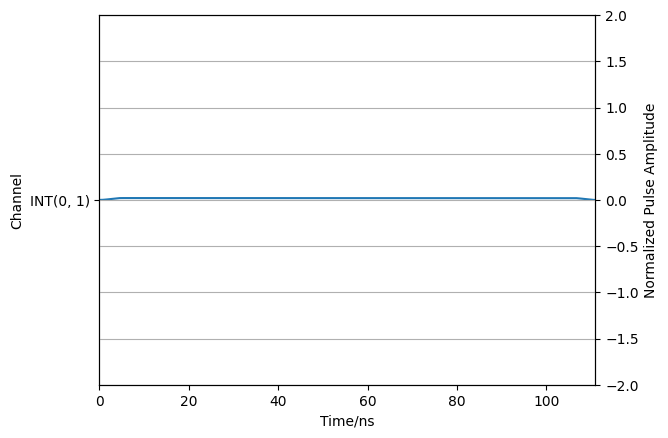

0

In [431]:
t_width = 10; bisa_amp = 20e-3

simulation_option = {
    "simulation_time": 111, # ns
    "simulation_step": 10000,
    "initial_state": [state_00, state_01, state_10, state_11] # Do multiple simulation
}

noise_chan1 = [
    {
    'type': 'white',
    'switch': 'off',
    'std': bisa_amp*0.3,
    }
]
noise_chan2 = [
    {
    'type': '1/f',
    'switch': 'on',
    'scale': 0.3,
    'alpha': 0.9,
    }
]
noise_chan3 = [
    {
    'type': '1/f',
    'switch': 'on',
    'scale': 0.12,
    'alpha': 0.92,
    }
]
noise_chan4 = [
    {
    'type': 'gaussian',
    'switch': 'on',
    'mean': 0,
    'std': 0.2
    }
]
noise_chan5 = [
    {
    'type': 'gaussian',
    'switch': 'on',
    'mean':0,
    'std': 0.1
    }
]

pulse_sequence = [
    {
        'pulse_index': 0, # [m,n] represents $\Omega_{mn}$
        'type': "INT",
        'pulse_shape': "cosine",
        't_delay': 0, # unit in ns
        't_width': t_width, # unit in ns
        't_plateau':simulation_option['simulation_time'] - t_width , # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': bisa_amp, # XY: Rabi freq; Z: biased frequency
        'q_index': (0,1),
        'noise': noise_chan1
    },
    # {
    #     'pulse_index': 1,
    #     'type': "Z",
    #     "pulse_shape": "square",
    #     't_delay': 0, # unit in ns
    #     't_width': 0, # unit in ns
    #     't_plateau':simulation_option['simulation_time'], # unit in ns
    #     'freq': 0, # unit in GHz; Z pulse does not use it
    #     'phase': 0, # unit in rad; Z pulse does not use it
    #     'amplitude': 0, # XY: Rabi freq; Z: biased frequency
    #     'q_index': 0,
    #     'noise': noise_chan2
    # },
    # {
    #     'pulse_index': 2,
    #     'type': "Z",
    #     "pulse_shape": "square",
    #     't_delay': 0, # unit in ns
    #     't_width': 0, # unit in ns
    #     't_plateau':simulation_option['simulation_time'], # unit in ns
    #     'freq': 0, # unit in GHz; Z pulse does not use it
    #     'phase': 0, # unit in rad; Z pulse does not use it
    #     'amplitude': 0, # XY: Rabi freq; Z: biased frequency
    #     'q_index': 1,
    #     'noise': noise_chan3
    # },
    # {
    #     'pulse_index': 3,
    #     'type': "XY",
    #     "pulse_shape": "square",
    #     't_delay': 0, # unit in ns
    #     't_width': 0, # unit in ns
    #     't_plateau':simulation_option['simulation_time'], # unit in ns
    #     'freq': 0, # unit in GHz; Z pulse does not use it
    #     'phase': 0, # unit in rad; Z pulse does not use it
    #     'amplitude': 0, # XY: Rabi freq; Z: biased frequency
    #     'q_index': 0,
    #     'noise': noise_chan4
    # },
    # {
    #     'pulse_index': 4,
    #     'type': "XY",
    #     "pulse_shape": "square",
    #     't_delay': 0, # unit in ns
    #     't_width': 0, # unit in ns
    #     't_plateau':simulation_option['simulation_time'], # unit in ns
    #     'freq': 0, # unit in GHz; Z pulse does not use it
    #     'phase': 0, # unit in rad; Z pulse does not use it
    #     'amplitude': 0, # XY: Rabi freq; Z: biased frequency
    #     'q_index': 1,
    #     'noise': noise_chan5
    # }
]

%matplotlib inline
## Notice that the all pulses'  amplitude are rescaled by a factor 1/1.2
pl.plot_pulse_sequence(pulse_sequence, simulation_option)

In [432]:
result_list, angle_list = _system_arb1.system_dynamics_mesolve(simulation_option, pulse_sequence)
propa_list = _system_arb1.system_dynamics_propagator(simulation_option, pulse_sequence)
angle_list

25.0%. Run time:   2.63s. Est. time left: 00:00:00:07
50.0%. Run time:   2.75s. Est. time left: 00:00:00:02
75.0%. Run time:   3.07s. Est. time left: 00:00:00:01
100.0%. Run time:   3.13s. Est. time left: 00:00:00:00
Total run time:   3.18s


[array([[5.38971886]]),
 array([[4.66343237]]),
 array([[5.29175071]]),
 array([[0.99154325]])]

In [433]:
U = propa_list[-1]
Usim = U/U.data[0,0]
Usim

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.74764569-0.66409783j  0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.99520496-0.09781151j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  -0.30906845+0.95103979j]]

In [434]:
# Construct a decoupled system
r_dic = {
    "r12": 0
}
r = tools.r2matrix(r_dic, freq_list) # Coupling strength
extra_list=None
_system_arb2 = aqs.arb_qubit_system(freq_list, inter_list, r, extra_list, gamma_list, driving_list, bias_list)

state_00, E_00, index_00 = _system_arb2.get_eigenstates_energy((0,0))
state_01, E_01, index_01 = _system_arb2.get_eigenstates_energy((0,1))
state_10, E_10, index_10 = _system_arb2.get_eigenstates_energy((1,0))
state_11, E_11, index_11 = _system_arb2.get_eigenstates_energy((1,1))
simulation_option2 = copy.deepcopy(simulation_option)
simulation_option2['initial_state'] = [state_00, state_01, state_10, state_11]
# simulation_option2['simulation_time'] = 154
pulse_sequence2 = [
    {
        'pulse_index': 1, # [m,n] represents $\Omega_{mn}$
        'type': "INT",
        'pulse_shape': "cosine",
        't_delay': 0, # unit in ns
        't_width': t_width, # unit in ns
        't_plateau':simulation_option2['simulation_time'] - t_width , # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': 0, # XY: Rabi freq; Z: biased frequency
        'q_index': (0,1)
    }
]

result_list2, angle_list2 = _system_arb2.system_dynamics_mesolve(simulation_option2, pulse_sequence2)
angle_list2

[array([[0.]]),
 array([[3.7699635]]),
 array([[4.39828178]]),
 array([[1.88501191]])]

In [435]:
q_pmatrix = np.array([[1,0,0,0], 
              [0, np.exp(-1j*angle_list2[1][0][0]), 0, 0],
              [0,0, np.exp(-1j*angle_list2[2][0][0]), 0],
              [0,0,0, np.exp(-1j *angle_list2[3][0][0])]])
# single qubit rotation correcting phase gate during ZZ inter
q_phase_gate = Qobj(q_pmatrix,
              dims = [[2,2], [2,2]])
q_phase_gate

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j         -0.80898624+0.58782757j  0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j         -0.30896748+0.9510726j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  -0.30907055-0.95103911j]]

In [436]:
# Correcting single qubit phase during ZZ inter
Usim_p = Usim * q_phase_gate
Usim_p

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j -0.21446006+9.76732760e-01j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
  -0.21446012+9.76732746e-01j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  1.        -2.20838679e-06j]]

In [19]:
# Phase gate after ZZ inter, correcting single qubit phase
phi12 = -np.angle(Usim_p.data[1,1])
c_pmatrix = np.array([[1,0,0,0], 
              [0, np.exp(1j*phi12), 0, 0],
              [0,0, np.exp(1j*phi12), 0],
              [0,0,0, np.exp(1j *2*phi12)]])
# correcting phase gate
c_phase_gate = Qobj(c_pmatrix,
              dims = [[2,2], [2,2]])
c_phase_gate

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j         -0.13601307-0.99070704j  0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j         -0.13601307-0.99070704j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  -0.96300089+0.26949821j]]

In [20]:
Uphase = Usim_p * c_phase_gate
Uphase

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.00000000e+00+0.j          9.57395942e-02-0.01135327j
   2.18804317e-01-0.04239666j  2.52177950e-03+0.00382085j]
 [-9.31898936e-02-0.01478346j  1.02174069e+00+0.j
  -1.81228326e-02+0.01650461j -5.73855167e-02+0.0473042j ]
 [-2.13688423e-01-0.0590355j  -8.07246633e-04+0.00660712j
   9.94354307e-01+0.07493354j -4.12229317e-02-0.11722557j]
 [ 1.54109863e-02-0.02645222j -6.96384749e-02-0.0290728j
  -1.23600087e-02+0.11918943j -9.74235610e-01+0.29809416j]]

#### Cal ideal Uphase

In [21]:
Uphase_ideal_matrix = np.array([[1,0,0,0], 
              [0, 1, 0, 0],
              [0,0, 1, 0],
              [0,0,0, np.exp(1j*2*phi12)]])
Uphase_ideal = Qobj(Uphase_ideal_matrix, dims= [[2,2], [2,2]])
Uphase_ideal


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          1.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          1.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  -0.96300089+0.26949821j]]

In [22]:
pickle.dump(Uphase_ideal_matrix, open('../../../Data/Uphase_ideal.pkl', 'wb'))

#### Load ideal Uphase and cal fidelity

In [23]:
Uphase_ideal_matrix = pickle.load(open('../../../Data/Uphase_ideal.pkl', 'rb'))
Uphase_ideal = Qobj(Uphase_ideal_matrix, dims= [[2,2], [2,2]])
Uphase_ideal

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          1.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          1.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  -0.96300089+0.26949821j]]

In [24]:
f = (1/4*(Uphase_ideal*Uphase.dag()).tr())
f = abs(f)
print('Fidelity:{: .10%}'.format(f))##### fidelity

Fidelity: 100.8733918711%


In [55]:
Uphase

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j         -0.04292607+0.00775256j -0.08833023+0.15147564j
   0.0088594 -0.00788683j]
 [ 0.04410601+0.00964278j  0.99784837+0.j          0.00801811-0.01237505j
  -0.0177106 -0.18580702j]
 [ 0.08671428+0.1523959j  -0.01484529+0.00155633j  0.99516605+0.00985924j
  -0.10663105+0.00122122j]
 [-0.00263655+0.0010269j   0.07986761+0.16906934j -0.09194397+0.0540306j
  -0.85672004+0.50246463j]]

## Physical spin case
### Define system

$$
H = \sum_{i=1}^2 B_z^i \sigma_z^i + \sum_{i=1}^2 J_{ij} \vec{\sigma}^i \cdot \vec{\sigma}^j
$$

or, effectively

* Single spin freq
$\omega_i = g\mu_B B_i$
here, $g=2$, $omega_i = [0, 15, 25, 28]$ MHz. Good case: $omega_i = [0, 150, 250, 350]$ MHz .

* Static coupling
$J_{ij} \approx 0.5\sim 1MHz$

* Bias amp: $J_{23} = 20 \sim 100 MHz$


In [87]:
freq_list = [ # GHz
    [0, 10.35],
    [0, 10],
    [0, 10.25],
    [0, 10.15]
]
inter_list = [
    [{
        "v01": 0,
        "v00": 1,
        "v11": -1
    },
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    }
    ,
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    },
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    }]
    ,
    [{
        "v01": 1,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": 1,
        "v00": 0,
        "v11": 0
    }
    ,
    {
        "v01": 1,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": 1,
        "v00": 0,
        "v11": 0
    }]
    ,
    [{
        "v01": -1j,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": -1j,
        "v00": 0,
        "v11": 0
    }
    ,
    {
        "v01": -1j,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": -1j,
        "v00": 0,
        "v11": 0
    }]
]
r_dic = { # 04/12/24 change residual coupling
    "r12": 1e-3,
    "r23": 1e-3,
    "r34": 1e-3
}
r = tools.r2matrix(r_dic, freq_list) 
extra_list=None
driving_list = [
    {
        "W01": 1j   # W01 represents \Omega_{01}, for the qubit with index 0
    },
    {
        "W01": 1j
    },
    {
        "W01": 1j
    },
    {
        "W01": 1j
    }
]
bias_list = [ 
    {
        "Z11": 1
    },
    {
        "Z11": 1
    },
    {
        "Z11": 1
    },
    {
        "Z11": 1
    }
]

gamma_list = None

_system_arb1 = aqs.arb_qubit_system(freq_list, inter_list, r, extra_list, gamma_list, driving_list, bias_list)

state_0000, E_0000, _= _system_arb1.get_eigenstates_energy((0,0,0,0))

state_0001, E_0001, _= _system_arb1.get_eigenstates_energy((0,0,0,1))
state_0010, E_0010, _= _system_arb1.get_eigenstates_energy((0,0,1,0))
state_0100, E_0100, _= _system_arb1.get_eigenstates_energy((0,1,0,0))
state_1000, E_1000, _= _system_arb1.get_eigenstates_energy((1,0,0,0))

"""subspace"""
state_0101, E_0101, index_0101= _system_arb1.get_eigenstates_energy((0,1,0,1))
state_1001, E_1001, index_1001= _system_arb1.get_eigenstates_energy((1,0,0,1))
state_0110, E_0110, index_0110= _system_arb1.get_eigenstates_energy((0,1,1,0))
state_1010, E_1010, index_1010= _system_arb1.get_eigenstates_energy((1,0,1,0))

"""leakage"""
state_0011, E_0011, index_0011= _system_arb1.get_eigenstates_energy((0,0,1,1))
state_1100, E_1100, index_1100= _system_arb1.get_eigenstates_energy((1,1,0,0))

state_0111, E_0111, _= _system_arb1.get_eigenstates_energy((0,1,1,1))
state_1011, E_1011, _= _system_arb1.get_eigenstates_energy((1,0,1,1))
state_1101, E_1101, _= _system_arb1.get_eigenstates_energy((1,1,0,1))
state_1110, E_1110, _= _system_arb1.get_eigenstates_energy((1,1,1,0))

state_1111, E_1111, _= _system_arb1.get_eigenstates_energy((1,1,1,1))

state_ud = Qobj(np.array([0,0,1,0]), dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket)
state_du = Qobj(np.array([0,1,0,0]), dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket)

state_dudu = tensor(state_du,state_du)
state_duud = tensor(state_du,state_ud)
state_uddu = tensor(state_ud,state_du)
state_udud = tensor(state_ud,state_ud)

_system_arb1.H

Quantum object: dims = [[2, 2, 2, 2], [2, 2, 2, 2]], shape = (16, 16), type = oper, isherm = True
Qobj data =
[[1.88495559e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.37806141e+01 1.25663706e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.25663706e-02 6.43963662e+01 0.00000000e+00
  1.25663706e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.28183263e+02
  0.00000000e+00 1.25663706e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.

### Energy level



#### $\omega_2$ scan

In [19]:
num_level = 16 # Num of level we want to see
w2_scan_space= np.linspace(9, 12, 800)
w =copy.deepcopy(freq_list)

energy_level_list = []
for w2 in w2_scan_space:
    dummy_list = []
    w[1][1] = w2
    _system_arb1 = aqs.arb_qubit_system(w, inter_list, r, extra_list, gamma_list, driving_list, bias_list)
    for j in range(0,num_level):
        dummy_list.append((_system_arb1.H.eigenenergies()[j] / np.pi/2).real)
    energy_level_list.append(dummy_list)

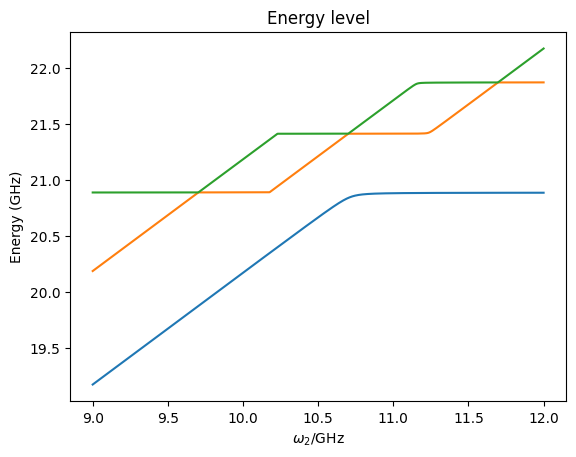

0

In [20]:
%matplotlib inline
pl.plot_Elevel_dynamics(w2_scan_space, energy_level_list, [index_0101, index_1100, index_0011], "\omega_2")

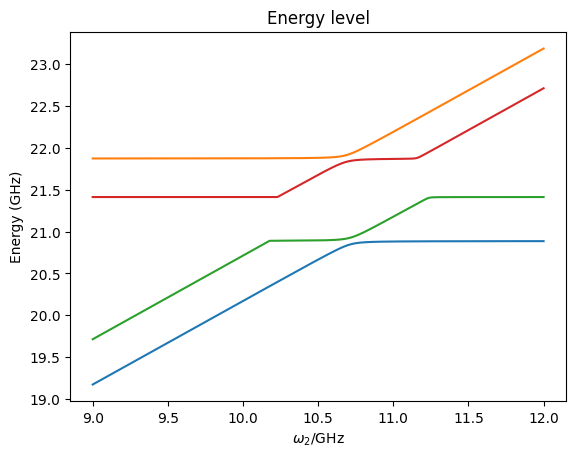

0

In [21]:
# %matplotlib qt
pl.plot_Elevel_dynamics(w2_scan_space, energy_level_list, [index_0101, index_1010, index_0110, index_1001], "\omega_2")

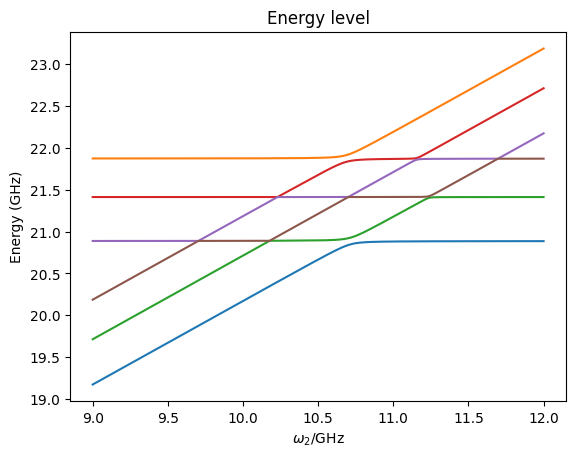

0

In [22]:
# %matplotlib qt
pl.plot_Elevel_dynamics(w2_scan_space, energy_level_list, [index_0101, index_1010, index_0110, index_1001, index_0011, index_1100], "\omega_2")

#### $J_{23}$ scan

In [486]:
num_level = 16 # Num of level we want to see
j23_scan_space= np.linspace(0.01e-3, 300e-3, 1000)
j_dic =copy.deepcopy(r_dic)

energy_level_list = []
for j23 in j23_scan_space:
    dummy_list = []
    j_dic["r23"] = j23
    j_matrix = tools.r2matrix(j_dic, freq_list)
    _system_arb1 = aqs.arb_qubit_system(freq_list, inter_list, j_matrix, extra_list, gamma_list, driving_list, bias_list)
    for j in range(0,num_level):
        dummy_list.append((_system_arb1.H.eigenenergies()[j] / np.pi/2).real)
    energy_level_list.append(dummy_list)

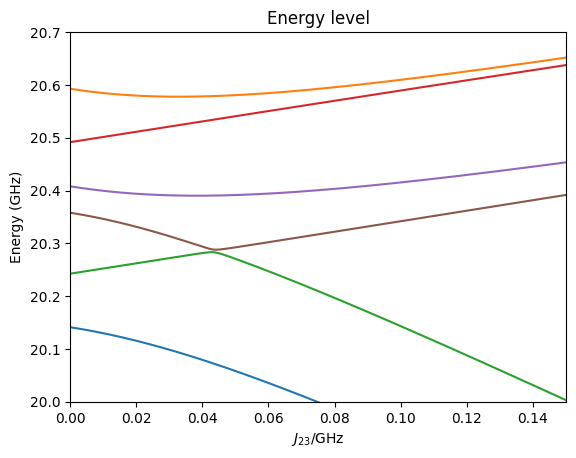

0

In [488]:
%matplotlib inline
pl.plot_Elevel_dynamics(j23_scan_space, energy_level_list, [index_0101, index_1010, index_0110, index_1001, index_0011, index_1100], "J_{23}", xrange=[0,150e-3], yrange=[20,20.7])

In [6]:
print(f'Subspace: E1010={E_1010}, E1001={E_1001}, E_0110={E_0110}, E0101={E_0101}')
print(f'Leakage space: E0011={E_0011}, E1100={E_1100}')

Subspace: E1010=20.58973531704359, E1001=20.497106910615866, E_0110=20.246854742870802, E0101=20.13833163005582
Leakage space: E0011=20.40324132216826, E1100=20.352730077245685


In [7]:
print(f'Subspace: index1010={index_1010}, index1001={index_1001}, Eindex0110={index_0110}, index0101={index_0101}')
print(f'Leakage space: index0011={index_0011}, index1100={index_1100}')

Subspace: index1010=10, index1001=9, Eindex0110=6, index0101=5
Leakage space: index0011=8, index1100=7


### System dynamics

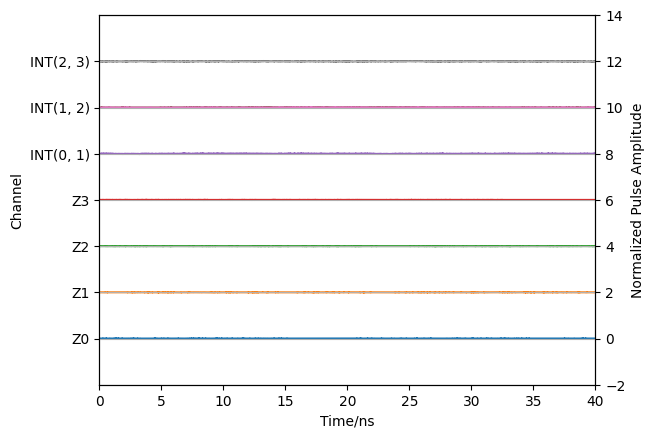

0

In [523]:
# t_width = 150; bisa_amp = 14.106e-3 
# or maybe 14.128e-3? as the baseline changed
bisa_amp = 11.128e-3; t_width = 40

simulation_option = {
    "simulation_time": t_width, # ns
    "simulation_step": 10000,
    "initial_state": [state_0101, state_0110, state_1001, state_1010] # Do multiple simulation
}

noise_chan1 = [
    {
    'type': 'white',
    'switch': 'on',
    'std': 1.43e-3,
    }
]
noise_chan2 = [
    {
    'type': 'gaussian',
    'switch': 'on',
    'mean': 0,
    'std': 1/(785),
    }
]
noise_chan3 = [
    {
    'type': '1/f',
    'switch': 'on',
    'scale': 0.002,
    'alpha': 1.2,
    }
]

pulse_sequence = [
    {
        'pulse_index': 0, # [m,n] represents $\Omega_{mn}$
        'type': "INT",
        'pulse_shape': "cosine",
        't_delay': 0, # unit in ns
        't_width': t_width, # unit in ns
        't_plateau':simulation_option['simulation_time'] - t_width , # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': bisa_amp, # XY: Rabi freq; Z: biased frequency
        'q_index': (1,2),
        'noise': noise_chan1
    },
    {
        'pulse_index': 1,
        'type': "Z",
        "pulse_shape": "square",
        't_delay': 0, # unit in ns
        't_width': 0, # unit in ns
        't_plateau':simulation_option['simulation_time'], # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': 0, # XY: Rabi freq; Z: biased frequency
        'q_index': 0,
        'noise': noise_chan2
    },
    {
        'pulse_index': 2,
        'type': "Z",
        "pulse_shape": "square",
        't_delay': 0, # unit in ns
        't_width': 0, # unit in ns
        't_plateau':simulation_option['simulation_time'], # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': 0, # XY: Rabi freq; Z: biased frequency
        'q_index': 1,
        'noise': noise_chan2
    },
    {
        'pulse_index': 3,
        'type': "Z",
        "pulse_shape": "square",
        't_delay': 0, # unit in ns
        't_width': 0, # unit in ns
        't_plateau':simulation_option['simulation_time'], # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': 0, # XY: Rabi freq; Z: biased frequency
        'q_index': 2,
        'noise': noise_chan2
    },
    {
        'pulse_index': 3,
        'type': "Z",
        "pulse_shape": "square",
        't_delay': 0, # unit in ns
        't_width': 0, # unit in ns
        't_plateau':simulation_option['simulation_time'], # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': 0, # XY: Rabi freq; Z: biased frequency
        'q_index': 3,
        'noise': noise_chan2
    },
    {
        'pulse_index': 4,
        'type': "INT",
        "pulse_shape": "square",
        't_delay': 0, # unit in ns
        't_width': 0, # unit in ns
        't_plateau':simulation_option['simulation_time'], # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': 0, # XY: Rabi freq; Z: biased frequency
        'q_index': (0,1),
        'noise': noise_chan3
    },
    {
        'pulse_index': 5,
        'type': "INT",
        "pulse_shape": "square",
        't_delay': 0, # unit in ns
        't_width': 0, # unit in ns
        't_plateau':simulation_option['simulation_time'], # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': 0, # XY: Rabi freq; Z: biased frequency
        'q_index': (2,3),
        'noise': noise_chan3
    },
    {
        'pulse_index': 6,
        'type': "INT",
        "pulse_shape": "square",
        't_delay': 0, # unit in ns
        't_width': 0, # unit in ns
        't_plateau':simulation_option['simulation_time'], # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': 0, # XY: Rabi freq; Z: biased frequency
        'q_index': (1,2),
        'noise': noise_chan3
    }
]

%matplotlib inline
## Notice that the all pulses'  amplitude are rescaled by a factor 1/1.2
pl.plot_pulse_sequence(pulse_sequence, simulation_option)

In [524]:
result_list, angle_list = _system_arb1.system_dynamics_mesolve(simulation_option, pulse_sequence)
propa_list = _system_arb1.system_dynamics_propagator(simulation_option, pulse_sequence)
angle_list

12.5%. Run time:   5.05s. Est. time left: 00:00:00:35
25.0%. Run time:   5.67s. Est. time left: 00:00:00:17
31.2%. Run time:   5.74s. Est. time left: 00:00:00:12
43.8%. Run time:   6.26s. Est. time left: 00:00:00:08
50.0%. Run time:   6.35s. Est. time left: 00:00:00:06
62.5%. Run time:   6.93s. Est. time left: 00:00:00:04
75.0%. Run time:   7.09s. Est. time left: 00:00:00:02
81.2%. Run time:   7.17s. Est. time left: 00:00:00:01
93.8%. Run time:   7.76s. Est. time left: 00:00:00:00
100.0%. Run time:   7.84s. Est. time left: 00:00:00:00
Total run time:   7.90s


[array([[4.99619776]]),
 array([[5.8077396]]),
 array([[6.03667699]]),
 array([[3.70564001]])]

In [352]:
for i in range(4):
    print(f'state index {i} leakages to 0011: {np.abs((state_0011.dag() * result_list[i].states[-1]).data[0,0])}')
    print(f'state index {i} leakages to 1100: {np.abs((state_1100.dag() * result_list[i].states[-1]).data[0,0])}')

state index 0 leakages to 0011: 0.03533309680957304
state index 0 leakages to 1100: 0.0013148397546403274
state index 1 leakages to 0011: 0.008855197611409193
state index 1 leakages to 1100: 0.014863536296391115
state index 2 leakages to 0011: 0.0017389987910047342
state index 2 leakages to 1100: 0.004095336643936035
state index 3 leakages to 0011: 0.0010233788217107913
state index 3 leakages to 1100: 0.07970015677407913


In [525]:
U = propa_list[-1] # get the Unitary 

# Perform partial trace, tracing out the coupler degree of freedom
slist = [
    state_0101, state_0110, state_1001, state_1010
]
sdlist = [
    state_0101.dag(), state_0110.dag(), state_1001.dag(), state_1010.dag()
]
dims = [len(sdlist), len(slist)];   umatrix = []
for i in range(dims[0]):
    umatrix_row = []
    for j in range(dims[1]):
        umatrix_row.append(sdlist[i] * U * slist[j])
    umatrix.append(umatrix_row)

Usim = Qobj(np.array(umatrix).reshape(dims[0],dims[1]), dims = [[int(np.sqrt(dims[0])), int(np.sqrt(dims[0]))], [int(np.sqrt(dims[1])), int(np.sqrt(dims[1]))]])
Usim = Usim/Usim.data[0,0]
Usim

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.00000000e+00+0.00000000e+00j  5.57543514e-03-2.85266839e-02j
  -3.92332709e-03-1.32932245e-02j  8.15930669e-04-8.55188361e-04j]
 [ 1.67039423e-02-2.38959921e-02j  6.96080455e-01+7.18187535e-01j
   8.55104186e-04+1.29960113e-04j  2.17022404e-02+2.37592381e-04j]
 [ 1.35425208e-02-3.40699644e-03j  1.45894220e-04-5.89927070e-04j
   5.13932861e-01+8.58060412e-01j -2.58086133e-02-1.92458289e-02j]
 [-8.82589683e-04+6.71141909e-04j -1.89164874e-02+1.07124002e-02j
   1.96592204e-02-2.53165456e-02j  2.67289169e-01-9.63260937e-01j]]

In [526]:
# Construct a decoupled system
r_dic = {
    "r12": 0,
    "r23": 0,
    "r34": 0
}
r = tools.r2matrix(r_dic, freq_list) # Coupling strength
extra_list=None
_system_arb2 = aqs.arb_qubit_system(freq_list, inter_list, r, extra_list, gamma_list, driving_list, bias_list)

"""subspace"""
state_0101, E_0101, index_0101= _system_arb1.get_eigenstates_energy((0,1,0,1))
state_1001, E_1001, index_1001= _system_arb1.get_eigenstates_energy((1,0,0,1))
state_0110, E_0110, index_0110= _system_arb1.get_eigenstates_energy((0,1,1,0))
state_1010, E_1010, index_1010= _system_arb1.get_eigenstates_energy((1,0,1,0))
simulation_option2 = copy.deepcopy(simulation_option)
simulation_option2['initial_state'] = [state_0101, state_0110, state_1001, state_1010]
# simulation_option2['simulation_time'] = 112
pulse_sequence2 = [
    {
        'pulse_index': 1, # [m,n] represents $\Omega_{mn}$
        'type': "INT",
        'pulse_shape': "cosine",
        't_delay': 0, # unit in ns
        't_width': t_width, # unit in ns
        't_plateau':simulation_option2['simulation_time'] - t_width , # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': 0, # XY: Rabi freq; Z: biased frequency
        'q_index': (1,2)
    }
]

print(f'Subspace: index1010={index_1010}, index1001={index_1001}, Eindex0110={index_0110}, index0101={index_0101}')
print(f'Leakage space: index0011={index_0011}, index1100={index_1100}')

result_list2, angle_list2 = _system_arb2.system_dynamics_mesolve(simulation_option2, pulse_sequence2)
angle_list2

Subspace: index1010=10, index1001=9, Eindex0110=6, index0101=5
Leakage space: index0011=8, index1100=7


[array([[6.28303443]]),
 array([[6.28303263]]),
 array([[6.28302895]]),
 array([[6.28302739]])]

In [527]:
q_pmatrix = np.array([[np.exp(-1j*angle_list2[0][0][0]),0,0,0], 
              [0, np.exp(-1j*angle_list2[1][0][0]), 0, 0],
              [0,0, np.exp(-1j*angle_list2[2][0][0]), 0],
              [0,0,0, np.exp(-1j *angle_list2[3][0][0])]])
# single qubit rotation correcting phase gate during ZZ inter
q_phase_gate = Qobj(q_pmatrix,
              dims = [[2,2], [2,2]])
q_phase_gate = q_phase_gate/q_phase_gate.data[0,0]
q_phase_gate

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[1.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
  0.+0.00000000e+00j]
 [0.+0.00000000e+00j 1.+1.80387286e-06j 0.+0.00000000e+00j
  0.+0.00000000e+00j]
 [0.+0.00000000e+00j 0.+0.00000000e+00j 1.+5.48018416e-06j
  0.+0.00000000e+00j]
 [0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
  1.+7.04409868e-06j]]

In [528]:
Usim_p = Usim * q_phase_gate
Usim_p

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.00000000e+00+0.00000000e+00j  5.57548660e-03-2.85266738e-02j
  -3.92325424e-03-1.32932460e-02j  8.15936693e-04-8.55182613e-04j]
 [ 1.67039423e-02-2.38959921e-02j  6.96079160e-01+7.18188790e-01j
   8.55103474e-04+1.29964799e-04j  2.17022387e-02+2.37745253e-04j]
 [ 1.35425208e-02-3.40699644e-03j  1.45895285e-04-5.89926807e-04j
   5.13928158e-01+8.58063229e-01j -2.58084777e-02-1.92460107e-02j]
 [-8.82589683e-04+6.71141909e-04j -1.89165067e-02+1.07123661e-02j
   1.96593592e-02-2.53164378e-02j  2.67295955e-01-9.63259054e-01j]]

In [529]:
# Phase gate after ZZ inter, correcting single qubit phase
phi12 = -np.angle(Usim_p.data[1,1])
phi34 = -np.angle(Usim_p.data[2,2])
c_pmatrix = np.array([[1,0,0,0], 
              [0, np.exp(1j*phi12), 0, 0],
              [0,0, np.exp(1j*phi34), 0],
              [0,0,0, np.exp(1j *(phi12+phi34))]])
# correcting phase gate
c_phase_gate = Qobj(c_pmatrix,
              dims = [[2,2], [2,2]])
c_phase_gate

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.69596735-0.71807343j  0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.51382678-0.85789396j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  -0.2584242 -0.96603154j]]

In [530]:
Uphase = Usim_p * c_phase_gate
Uphase

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.00000000e+00+0.j         -1.66038898e-02-0.02385724j
  -1.34200685e-02-0.00346469j -1.03699116e-03-0.00056722j]
 [ 1.67039423e-02-0.02389599j  1.00016065e+00+0.j
   5.50871077e-04-0.00066681j -5.37871420e-03-0.02102649j]
 [ 1.35425208e-02-0.003407j   -3.22072410e-04-0.00051533j
   1.00019731e+00+0.j         -1.19227182e-02+0.02990544j]
 [-8.82589683e-04+0.00067114j -5.47300560e-03+0.0210389j
  -1.16173139e-02-0.02987391j -9.99614369e-01-0.00928687j]]

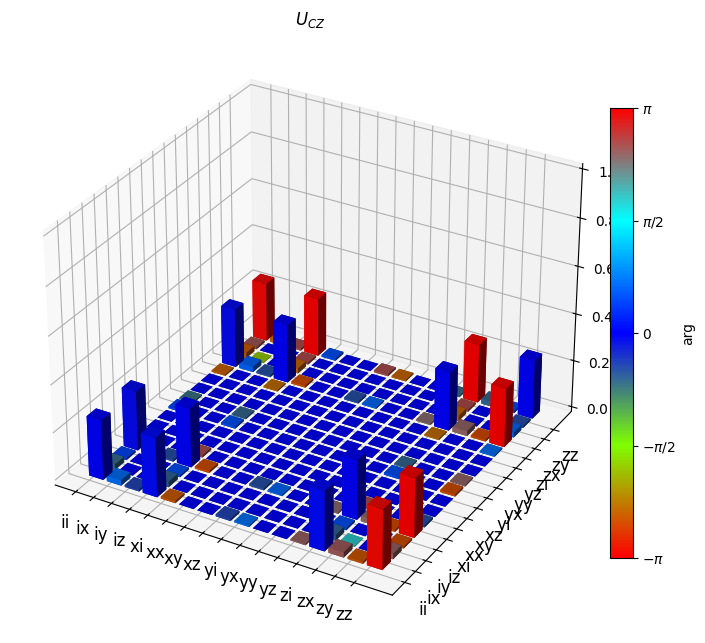

In [359]:
from qutip.tomography import qpt, qpt_plot_combined

U_rho = spre(Uphase) * spost(Uphase.dag())
op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()]] * 2
op_label = [["i", "x", "y", "z"]] * 2
chi = qpt(U_rho, op_basis)
fig = qpt_plot_combined(chi, op_label, r'$U_{CZ}$')
%matplotlib inline
plt.show()

#### Cal ideal Cphase

In [513]:
Uphase_ideal_matrix = np.array([[1,0,0,0], 
              [0, 1, 0, 0],
              [0,0, 1, 0],
              [0,0,0, np.exp(1j*(np.pi))]])
Uphase_ideal = Qobj(Uphase_ideal_matrix, dims= [[2,2], [2,2]])
Uphase_ideal

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.+0.0000000e+00j  0.+0.0000000e+00j  0.+0.0000000e+00j
   0.+0.0000000e+00j]
 [ 0.+0.0000000e+00j  1.+0.0000000e+00j  0.+0.0000000e+00j
   0.+0.0000000e+00j]
 [ 0.+0.0000000e+00j  0.+0.0000000e+00j  1.+0.0000000e+00j
   0.+0.0000000e+00j]
 [ 0.+0.0000000e+00j  0.+0.0000000e+00j  0.+0.0000000e+00j
  -1.+1.2246468e-16j]]

In [ ]:
pickle.dump(Uphase_ideal_matrix, open('../../../Data/Uphase_ideal_4spin.pkl', 'wb'))

#### Load ideal Uphase and calculate fidelity

In [278]:
Uphase_ideal_matrix = pickle.load(open('../../../Data/Uphase_ideal_4spin.pkl', 'rb'))
Uphase_ideal = Qobj(Uphase_ideal_matrix, dims= [[2,2], [2,2]])
Uphase_ideal

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[1.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         1.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         1.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.85793813+0.51375303j]]

In [414]:
# f = (1/4*(Uphase_ideal*Uphase.dag()).tr())
f = average_gate_fidelity(Uphase, Uphase_ideal)
# f = process_fidelity(Uphase, Uphase_ideal, normalize=True) # (U1 * U2).tr() / (U1.tr() * U2.tr())
f = abs(f)
print('Fidelity:{: .10%}'.format(f))##### fidelity


Fidelity: 99.9994348747%


## Ideal physical 4-spin case


In [2]:
freq_list = [ # GHz
    [0, 10.35],
    [0, 10],
    [0, 10.25],
    [0, 10.15]
]
inter_list = [
    [{
        "v01": 0,
        "v00": 1,
        "v11": -1
    },
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    }
    ,
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    },
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    }]
    ,
    [{
        "v01": 1,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": 1,
        "v00": 0,
        "v11": 0
    }
    ,
    {
        "v01": 1,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": 1,
        "v00": 0,
        "v11": 0
    }]
    ,
    [{
        "v01": -1j,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": -1j,
        "v00": 0,
        "v11": 0
    }
    ,
    {
        "v01": -1j,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": -1j,
        "v00": 0,
        "v11": 0
    }]
]
r_dic = { # 04/12/24 change residual coupling
    "r12": 1e-3,
    "r23": 1e-3,
    "r34": 1e-3
}
r = tools.r2matrix(r_dic, freq_list) 
extra_list=None
driving_list = [
    {
        "W01": 1j   # W01 represents \Omega_{01}, for the qubit with index 0
    },
    {
        "W01": 1j
    },
    {
        "W01": 1j
    },
    {
        "W01": 1j
    }
]
bias_list = [ 
    {
        "Z11": 1
    },
    {
        "Z11": 1
    },
    {
        "Z11": 1
    },
    {
        "Z11": 1
    }
]

gamma_list = None

_system_arb1 = aqs.arb_qubit_system(freq_list, inter_list, r, extra_list, gamma_list, driving_list, bias_list)

state_0000, E_0000, _= _system_arb1.get_eigenstates_energy((0,0,0,0))

state_0001, E_0001, _= _system_arb1.get_eigenstates_energy((0,0,0,1))
state_0010, E_0010, _= _system_arb1.get_eigenstates_energy((0,0,1,0))
state_0100, E_0100, _= _system_arb1.get_eigenstates_energy((0,1,0,0))
state_1000, E_1000, _= _system_arb1.get_eigenstates_energy((1,0,0,0))

"""subspace"""
state_0101, E_0101, index_0101= _system_arb1.get_eigenstates_energy((0,1,0,1))
state_1001, E_1001, index_1001= _system_arb1.get_eigenstates_energy((1,0,0,1))
state_0110, E_0110, index_0110= _system_arb1.get_eigenstates_energy((0,1,1,0))
state_1010, E_1010, index_1010= _system_arb1.get_eigenstates_energy((1,0,1,0))

"""leakage"""
state_0011, E_0011, index_0011= _system_arb1.get_eigenstates_energy((0,0,1,1))
state_1100, E_1100, index_1100= _system_arb1.get_eigenstates_energy((1,1,0,0))

state_0111, E_0111, _= _system_arb1.get_eigenstates_energy((0,1,1,1))
state_1011, E_1011, _= _system_arb1.get_eigenstates_energy((1,0,1,1))
state_1101, E_1101, _= _system_arb1.get_eigenstates_energy((1,1,0,1))
state_1110, E_1110, _= _system_arb1.get_eigenstates_energy((1,1,1,0))

state_1111, E_1111, _= _system_arb1.get_eigenstates_energy((1,1,1,1))

state_ud = Qobj(np.array([0,0,1,0]), dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket)
state_du = Qobj(np.array([0,1,0,0]), dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket)

state_dudu = tensor(state_du,state_du)
state_duud = tensor(state_du,state_ud)
state_uddu = tensor(state_ud,state_du)
state_udud = tensor(state_ud,state_ud)

_system_arb1.H

Quantum object: dims = [[2, 2, 2, 2], [2, 2, 2, 2]], shape = (16, 16), type = oper, isherm = True
Qobj data =
[[1.88495559e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.37806141e+01 1.25663706e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.25663706e-02 6.43963662e+01 0.00000000e+00
  1.25663706e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.28183263e+02
  0.00000000e+00 1.25663706e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.

### Setup pulse

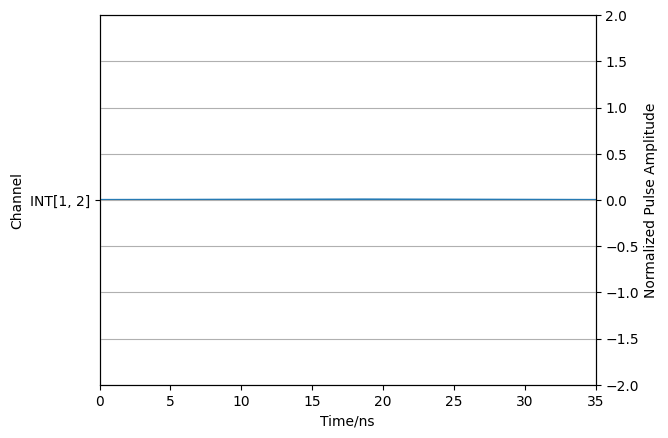

0

In [3]:
# t_width = 150; bisa_amp = 14.106e-3 
# or maybe 14.128e-3? as the baseline changed
bisa_amp =5.152e-3 # 16.8045e-3; 
t_width =35 #40

simulation_option = {
    "simulation_time": t_width, # ns
    "simulation_step": 10000,
    "initial_state": [state_dudu, state_duud, state_uddu, state_udud] # Do multiple simulation
}

pulse_sequence = [
    {
        'pulse_index': 0, # [m,n] represents $\Omega_{mn}$
        'type': "INT",
        'pulse_shape': "cosine",
        't_delay': 0, # unit in ns
        't_width': t_width, # unit in ns
        't_plateau':simulation_option['simulation_time'] - t_width , # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': bisa_amp, # XY: Rabi freq; Z: biased frequency
        'q_index': [1,2]
    }
]

%matplotlib inline
## Notice that the all pulses'  amplitude are rescaled by a factor 1/1.2
pl.plot_pulse_sequence(pulse_sequence, simulation_option)

#### dynamics

In [4]:
result_list, angle_list = _system_arb1.system_dynamics_mesolve(simulation_option, pulse_sequence)
propa_list = _system_arb1.system_dynamics_propagator(simulation_option, pulse_sequence)
angle_list

12.5%. Run time:   3.69s. Est. time left: 00:00:00:25
25.0%. Run time:   4.22s. Est. time left: 00:00:00:12
31.2%. Run time:   4.28s. Est. time left: 00:00:00:09
43.8%. Run time:   4.50s. Est. time left: 00:00:00:05
50.0%. Run time:   4.71s. Est. time left: 00:00:00:04
62.5%. Run time:   5.02s. Est. time left: 00:00:00:03
75.0%. Run time:   5.13s. Est. time left: 00:00:00:01
81.2%. Run time:   5.37s. Est. time left: 00:00:00:01
93.8%. Run time:   5.48s. Est. time left: 00:00:00:00
100.0%. Run time:   5.75s. Est. time left: 00:00:00:00
Total run time:   5.84s


[array([[6.00539045]]),
 array([[1.21808958]]),
 array([[2.8014461]]),
 array([[1.15681067]])]

#### partial trace of U

In [5]:
U = propa_list[-1] # get the Unitary 

# Perform partial trace, tracing out the coupler degree of freedom
slist = [
    state_dudu, state_duud, state_uddu, state_udud
]
sdlist = [
    state_dudu.dag(), state_duud.dag(), state_uddu.dag(), state_udud.dag()
]
dims = [len(sdlist), len(slist)];   umatrix = []
for i in range(dims[0]):
    umatrix_row = []
    for j in range(dims[1]):
        umatrix_row.append(sdlist[i] * U * slist[j])
    umatrix.append(umatrix_row)

Usim = Qobj(np.array(umatrix).reshape(dims[0],dims[1]), dims = [[int(np.sqrt(dims[0])), int(np.sqrt(dims[0]))], [int(np.sqrt(dims[1])), int(np.sqrt(dims[1]))]])
Usim = Usim/Usim.data[0,0]
Usim

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.00000000e+00+0.00000000e+00j -1.82187871e-02+1.96396028e-02j
  -1.13540142e-02+3.53661031e-04j  2.35275757e-04-5.46370320e-06j]
 [-1.82187146e-02+1.96396832e-02j  7.48473430e-02+9.97268709e-01j
   2.36295163e-04-2.80253176e-06j  3.50433328e-04-3.93634608e-05j]
 [-1.13540249e-02+3.53818178e-04j  2.36295463e-04-2.80477968e-06j
  -9.97982134e-01+6.23066376e-02j  2.30186308e-02+1.88522706e-02j]
 [ 2.35276259e-04-5.46772765e-06j  3.50441509e-04-3.93655954e-05j
   2.30187113e-02+1.88521906e-02j  1.35754727e-01+9.90627586e-01j]]

#### Single qubit phase cancel


In [6]:

# Construct a decoupled system
r_dic = {
    "r12": 0,
    "r23": 0,
    "r34": 0
}
r = tools.r2matrix(r_dic, freq_list) # Coupling strength
extra_list=None
_system_arb2 = aqs.arb_qubit_system(freq_list, inter_list, r, extra_list, gamma_list, driving_list, bias_list)

simulation_option2 = copy.deepcopy(simulation_option)
simulation_option2['initial_state'] = [state_dudu, state_duud, state_uddu, state_udud] 
# simulation_option2['simulation_time'] = t_width -2
pulse_sequence2 = [
    {
        'pulse_index': 1, # [m,n] represents $\Omega_{mn}$
        'type': "INT",
        'pulse_shape': "cosine",
        't_delay': 0, # unit in ns
        't_width': t_width, # unit in ns
        't_plateau':simulation_option2['simulation_time'] - t_width , # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': 0, # XY: Rabi freq; Z: biased frequency
        'q_index': [1,2]
    }
]


result_list2, angle_list2 = _system_arb2.system_dynamics_mesolve(simulation_option2, pulse_sequence2)
angle_list2

[array([[4.71226485]]),
 array([[1.57067147]]),
 array([[3.14146607]]),
 array([[6.28305804]])]

In [7]:
q_pmatrix = np.array([[np.exp(-1j*angle_list2[0][0][0]),0,0,0], 
              [0, np.exp(-1j*angle_list2[1][0][0]), 0, 0],
              [0,0, np.exp(-1j*angle_list2[2][0][0]), 0],
              [0,0,0, np.exp(-1j *angle_list2[3][0][0])]])
# single qubit rotation correcting phase gate during ZZ inter
q_phase_gate = Qobj(q_pmatrix,
              dims = [[2,2], [2,2]])
q_phase_gate = q_phase_gate/q_phase_gate.data[0,0]
q_phase_gate

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j -1.00000000e+00-7.20829008e-07j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -2.44807463e-06+1.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  3.13671919e-06-1.00000000e+00j]]

In [8]:
Usim_p = Usim * q_phase_gate
Usim_p

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.00000000e+00+0.00000000e+00j  1.82188013e-02-1.96395897e-02j
  -3.53633235e-04-1.13540151e-02j -5.46296521e-06-2.35275774e-04j]
 [-1.82187146e-02+1.96396832e-02j -7.48466242e-02-9.97268763e-01j
   2.80195329e-06+2.36295170e-04j -3.93623616e-05-3.50433451e-04j]
 [-1.13540249e-02+3.53818178e-04j -2.36295465e-04+2.80460935e-06j
  -6.23041945e-02-9.97982287e-01j  1.88523428e-02-2.30185717e-02j]
 [ 2.35276259e-04-5.46772765e-06j -3.50441538e-04+3.93653428e-05j
  -1.88522469e-02+2.30186652e-02j  9.90628012e-01-1.35751620e-01j]]

#### phase gate after ZZ inter

In [9]:
# Phase gate after ZZ inter, correcting single qubit phase
phi12 = -np.angle(Usim_p.data[1,1])
phi34 = -np.angle(Usim_p.data[2,2])
c_pmatrix = np.array([[1,0,0,0], 
              [0, np.exp(1j*phi12), 0, 0],
              [0,0, np.exp(1j*phi34), 0],
              [0,0,0, np.exp(1j *(phi12+phi34))]])
# correcting phase gate
c_phase_gate = Qobj(c_pmatrix,
              dims = [[2,2], [2,2]])
c_phase_gate

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j         -0.07484112+0.99719547j  0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j         -0.06230885+0.99805692j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  -0.99059457-0.13682981j]]

In [167]:
Uphase = Usim_p * c_phase_gate
# print(Uphase.data)
Uphase

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.00000000e+00+0.00000000e+00j  1.82209943e-02+1.96375551e-02j
   1.13539878e-02+3.54509568e-04j -2.67811552e-05+2.33810401e-04j]
 [-1.82187146e-02+1.96396832e-02j  1.00007350e+00+0.00000000e+00j
  -2.36010615e-04-1.19267723e-05j -8.95759999e-06+3.52523419e-04j]
 [-1.13540249e-02+3.53818178e-04j  1.48878743e-05-2.35842667e-04j
   9.99925226e-01+0.00000000e+00j -2.18246551e-02+2.02225097e-02j]
 [ 2.35276259e-04-5.46772765e-06j -1.30275031e-05-3.52404860e-04j
  -2.17992761e-02-2.02498821e-02j -9.99885598e-01-1.07262248e-03j]]

#### Ideal gate

In [168]:
Uphase_ideal_matrix = np.array([[1,0,0,0], 
              [0, 1, 0, 0],
              [0,0, 1, 0],
              [0,0,0, np.exp(1j*(np.pi))]])
Uphase_ideal = Qobj(Uphase_ideal_matrix, dims= [[2,2], [2,2]])
Uphase_ideal

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.+0.0000000e+00j  0.+0.0000000e+00j  0.+0.0000000e+00j
   0.+0.0000000e+00j]
 [ 0.+0.0000000e+00j  1.+0.0000000e+00j  0.+0.0000000e+00j
   0.+0.0000000e+00j]
 [ 0.+0.0000000e+00j  0.+0.0000000e+00j  1.+0.0000000e+00j
   0.+0.0000000e+00j]
 [ 0.+0.0000000e+00j  0.+0.0000000e+00j  0.+0.0000000e+00j
  -1.+1.2246468e-16j]]

In [169]:
f = (1/4*(Uphase_ideal*Uphase.dag()).tr())
# f = average_gate_fidelity(Uphase, Uphase_ideal)
# f = process_fidelity(Uphase, Uphase_ideal, normalize=True) # (U1 * U2).tr() / (U1.tr() * U2.tr())
f = abs(f)
print('Fidelity:{: .10%}'.format(f))##### fidelity

Fidelity: 99.9971116451%


## Repeat simulation

In [170]:
freq_list = [ # GHz
    [0, 10.35],
    [0, 10],
    [0, 10.25],
    [0, 10.15]
]

inter_list = [
    [{
        "v01": 0,
        "v00": 1,
        "v11": -1
    },
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    }
    ,
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    },
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    }],
    [{
        "v01": 1,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": 1,
        "v00": 0,
        "v11": 0
    }
    ,
    {
        "v01": 1,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": 1,
        "v00": 0,
        "v11": 0
    }]
    ,
    [{
        "v01": -1j,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": -1j,
        "v00": 0,
        "v11": 0
    }
    ,
    {
        "v01": -1j,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": -1j,
        "v00": 0,
        "v11": 0
    }]
]

r_dic = {
    "r12": 1e-3,
    "r23": 1e-3,
    "r34": 1e-3
}
r = tools.r2matrix(r_dic, freq_list) # Coupling strength

extra_list=None
## with pulse type XY
driving_list = [
    {
        "W01": 1j   # W01 represents \Omega_{01}, for the qubit with index 0
    },
    {
        "W01": 1j
    },
    {
        "W01": 1j
    },
    {
        "W01": 1j
    }
]

## with pulse type Z
bias_list = [ # Default, Z00 = 0
    {
        "Z11": 1
    },
    {
        "Z11": 1
    },
    {
        "Z11": 1
    },
    {
        "Z11": 1
    }
]

gamma_list = None

# gamma_list = None

_system_arb1 = aqs.arb_qubit_system(freq_list, inter_list, r, extra_list, gamma_list, driving_list, bias_list)

state_0000, E_0000, _= _system_arb1.get_eigenstates_energy((0,0,0,0))

state_0001, E_0001, _= _system_arb1.get_eigenstates_energy((0,0,0,1))
state_0010, E_0010, _= _system_arb1.get_eigenstates_energy((0,0,1,0))
state_0100, E_0100, _= _system_arb1.get_eigenstates_energy((0,1,0,0))
state_1000, E_1000, _= _system_arb1.get_eigenstates_energy((1,0,0,0))

"""subspace"""
state_0101, E_0101, index_0101= _system_arb1.get_eigenstates_energy((0,1,0,1))
state_1001, E_1001, index_1001= _system_arb1.get_eigenstates_energy((1,0,0,1))
state_0110, E_0110, index_0110= _system_arb1.get_eigenstates_energy((0,1,1,0))
state_1010, E_1010, index_1010= _system_arb1.get_eigenstates_energy((1,0,1,0))

"""leakage"""
state_0011, E_0011, index_0011= _system_arb1.get_eigenstates_energy((0,0,1,1))
state_1100, E_1100, index_1100= _system_arb1.get_eigenstates_energy((1,1,0,0))

state_0111, E_0111, _= _system_arb1.get_eigenstates_energy((0,1,1,1))
state_1011, E_1011, _= _system_arb1.get_eigenstates_energy((1,0,1,1))
state_1101, E_1101, _= _system_arb1.get_eigenstates_energy((1,1,0,1))
state_1110, E_1110, _= _system_arb1.get_eigenstates_energy((1,1,1,0))

state_1111, E_1111, _= _system_arb1.get_eigenstates_energy((1,1,1,1))

state_ud = Qobj(np.array([0,0,1,0]), dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket)
state_du = Qobj(np.array([0,1,0,0]), dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket)

state_dudu = tensor(state_du,state_du)
state_duud = tensor(state_du,state_ud)
state_uddu = tensor(state_ud,state_du)
state_udud = tensor(state_ud,state_ud)


repeat_time = 1000
bisa_amp = 5.152e-3# 11.128e-3;
t_width = 35

_system_arb1.H

Quantum object: dims = [[2, 2, 2, 2], [2, 2, 2, 2]], shape = (16, 16), type = oper, isherm = True
Qobj data =
[[1.88495559e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.37806141e+01 1.25663706e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.25663706e-02 6.43963662e+01 0.00000000e+00
  1.25663706e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.28183263e+02
  0.00000000e+00 1.25663706e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.

In [171]:
# Construct a decoupled system
r_dic2 = {
    "r12": 0,
    "r23": 0,
    "r34": 0
}
r2 = tools.r2matrix(r_dic2, freq_list) # Coupling strength
extra_list=None
_system_arb2 = aqs.arb_qubit_system(freq_list, inter_list, r2, extra_list, gamma_list, driving_list, bias_list)
simulation_option = {
    "simulation_time": t_width, # ns
    "simulation_step": 10000,
    "initial_state": [state_0101, state_0110, state_1001, state_1010] # Do multiple simulation
}

"""subspace"""
state_0101, E_0101, index_0101= _system_arb1.get_eigenstates_energy((0,1,0,1))
state_1001, E_1001, index_1001= _system_arb1.get_eigenstates_energy((1,0,0,1))
state_0110, E_0110, index_0110= _system_arb1.get_eigenstates_energy((0,1,1,0))
state_1010, E_1010, index_1010= _system_arb1.get_eigenstates_energy((1,0,1,0))
simulation_option2 = copy.deepcopy(simulation_option)
simulation_option2['initial_state'] = [state_dudu, state_duud, state_uddu, state_udud]
# simulation_option2['simulation_time'] = 154
pulse_sequence2 = [
    {
        'pulse_index': 1, # [m,n] represents $\Omega_{mn}$
        'type': "INT",
        'pulse_shape': "cosine",
        't_delay': 0, # unit in ns
        't_width': t_width, # unit in ns
        't_plateau':simulation_option2['simulation_time'] - t_width , # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': 0, # XY: Rabi freq; Z: biased frequency
        'q_index': [1,2]
    }
]

# print(f'Subspace: index1010={index_1010}, index1001={index_1001}, Eindex0110={index_0110}, index0101={index_0101}')
# print(f'Leakage space: index0011={index_0011}, index1100={index_1100}')

result_list2, angle_list2 = _system_arb2.system_dynamics_mesolve(simulation_option2, pulse_sequence2)

q_pmatrix = np.array([[np.exp(-1j*angle_list2[0][0][0]),0,0,0], 
              [0, np.exp(-1j*angle_list2[1][0][0]), 0, 0],
              [0,0, np.exp(-1j*angle_list2[2][0][0]), 0],
              [0,0,0, np.exp(-1j *angle_list2[3][0][0])]])
# single qubit rotation correcting phase gate during ZZ inter
q_phase_gate = Qobj(q_pmatrix,
              dims = [[2,2], [2,2]])
q_phase_gate = q_phase_gate/q_phase_gate.data[0,0]
q_phase_gate

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j -1.00000000e+00-7.20829008e-07j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -2.44807463e-06+1.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  3.13671919e-06-1.00000000e+00j]]

In [181]:
Q_factor = 20
1/np.sqrt(2)/np.pi/Q_factor

0.011253953951963826

In [175]:
leakage_list = []; angle_cphase=[]; Cphase_melements= []
Fd_avg = []; Fd_process = []; Fd_trace = []
Q_factor = 20
B_noise_std = 0.22e-3
J_noise_std = (1e-3)/np.sqrt(2)/np.pi/Q_factor
J23_noise_std = (bisa_amp+1e-3)/np.sqrt(2)/np.pi/Q_factor

Uphase_ideal_matrix = np.array([[1,0,0,0], 
              [0, 1, 0, 0],
              [0,0, 1, 0],
              [0,0,0, np.exp(1j*(np.pi))]])
Uphase_ideal = Qobj(Uphase_ideal_matrix, dims= [[2,2], [2,2]])

for rtime in tqdm(range(repeat_time)):
    pulse_sequence = [
        {
            'pulse_index': 0, # [m,n] represents $\Omega_{mn}$
            'type': "INT",
            'pulse_shape': "cosine",
            't_delay': 0, # unit in ns
            't_width': t_width, # unit in ns
            't_plateau':0 , # unit in ns
            'freq': 0, # unit in GHz; Z pulse does not use it
            'phase': 0, # unit in rad; Z pulse does not use it
            'amplitude': bisa_amp, # XY: Rabi freq; Z: biased frequency
            'q_index': [1,2],
        },
        {
            'pulse_index': 1,
            'type': "Z",
            "pulse_shape": "square",
            't_delay': 0, # unit in ns
            't_width': 0, # unit in ns
            't_plateau':simulation_option['simulation_time'], # unit in ns
            'freq': 0, # unit in GHz; Z pulse does not use it
            'phase': 0, # unit in rad; Z pulse does not use it
            'amplitude': np.random.normal(0, B_noise_std), # XY: Rabi freq; Z: biased frequency
            'q_index': 0,
        },
        {
            'pulse_index': 2,
            'type': "Z",
            "pulse_shape": "square",
            't_delay': 0, # unit in ns
            't_width': 0, # unit in ns
            't_plateau':simulation_option['simulation_time'], # unit in ns
            'freq': 0, # unit in GHz; Z pulse does not use it
            'phase': 0, # unit in rad; Z pulse does not use it
            'amplitude': np.random.normal(0, B_noise_std), # XY: Rabi freq; Z: biased frequency
            'q_index': 1,
        },
        {
            'pulse_index': 3,
            'type': "Z",
            "pulse_shape": "square",
            't_delay': 0, # unit in ns
            't_width': 0, # unit in ns
            't_plateau':simulation_option['simulation_time'], # unit in ns
            'freq': 0, # unit in GHz; Z pulse does not use it
            'phase': 0, # unit in rad; Z pulse does not use it
            'amplitude': np.random.normal(0, B_noise_std), # XY: Rabi freq; Z: biased frequency
            'q_index': 2,
        },
        {
            'pulse_index': 4,
            'type': "Z",
            "pulse_shape": "square",
            't_delay': 0, # unit in ns
            't_width': 0, # unit in ns
            't_plateau':simulation_option['simulation_time'], # unit in ns
            'freq': 0, # unit in GHz; Z pulse does not use it
            'phase': 0, # unit in rad; Z pulse does not use it
            'amplitude': np.random.normal(0, B_noise_std), # XY: Rabi freq; Z: biased frequency
            'q_index': 3,
        },
        {
            'pulse_index': 5,
            'type': "INT",
            "pulse_shape": "square",
            't_delay': 0, # unit in ns
            't_width': 0, # unit in ns
            't_plateau':simulation_option['simulation_time'], # unit in ns
            'freq': 0, # unit in GHz; Z pulse does not use it
            'phase': 0, # unit in rad; Z pulse does not use it
            'amplitude': np.random.normal(0, J_noise_std), # XY: Rabi freq; Z: biased frequency
            'q_index': [0,1],
        },
        {
            'pulse_index': 6,
            'type': "INT",
            "pulse_shape": "square",
            't_delay': 0, # unit in ns
            't_width': 0, # unit in ns
            't_plateau':simulation_option['simulation_time'], # unit in ns
            'freq': 0, # unit in GHz; Z pulse does not use it
            'phase': 0, # unit in rad; Z pulse does not use it
            'amplitude': np.random.normal(0, J_noise_std), # XY: Rabi freq; Z: biased frequency
            'q_index': [2,3],
        },
        {
            'pulse_index': 7,
            'type': "INT",
            "pulse_shape": "square",
            't_delay': 0, # unit in ns
            't_width': 0, # unit in ns
            't_plateau':simulation_option['simulation_time'], # unit in ns
            'freq': 0, # unit in GHz; Z pulse does not use it
            'phase': 0, # unit in rad; Z pulse does not use it
            'amplitude': np.random.normal(0, J23_noise_std), # XY: Rabi freq; Z: biased frequency
            'q_index': [1,2],
        }
    ]
    result_list, angle_list = _system_arb1.system_dynamics_mesolve(simulation_option, pulse_sequence)
    propa_list = _system_arb1.system_dynamics_propagator(simulation_option, pulse_sequence, do_progress_bar=None)
    lk_dummy = []
    for i in range(len(simulation_option["initial_state"])):
        lk = 1 - np.abs(((state_udud + state_dudu + state_duud + state_uddu ).dag()* result_list[i].states[-1]).data[0,0])
        lk_dummy.append(lk)
    leakage_list.append(np.average(lk_dummy))

    U = propa_list[-1] # get the Unitary 
    # Perform partial trace, tracing out the coupler degree of freedom
    slist = [
        state_dudu, state_duud, state_uddu, state_udud
    ]
    sdlist = [
        state_dudu.dag(), state_duud.dag(), state_uddu.dag(), state_udud.dag()
    ]
    dims = [len(sdlist), len(slist)];   umatrix = []
    for i in range(dims[0]):
        umatrix_row = []
        for j in range(dims[1]):
            umatrix_row.append(sdlist[i] * U * slist[j])
        umatrix.append(umatrix_row)

    Usim = Qobj(np.array(umatrix).reshape(dims[0],dims[1]), dims = [[int(np.sqrt(dims[0])), int(np.sqrt(dims[0]))], [int(np.sqrt(dims[1])), int(np.sqrt(dims[1]))]])
    Usim = Usim/Usim.data[0,0]
    Usim_p = Usim * q_phase_gate
    # Phase gate after ZZ inter, correcting single qubit phase
    # phi12 = -np.angle(Usim_p.data[1,1])
    # phi34 = -np.angle(Usim_p.data[2,2])
    # c_pmatrix = np.array([[1,0,0,0], 
    #             [0, np.exp(1j*phi12), 0, 0],
    #             [0,0, np.exp(1j*phi34), 0],
    #             [0,0,0, np.exp(1j *(phi12+phi34))]])
    # # correcting phase gate
    # c_phase_gate = Qobj(c_pmatrix,
    #             dims = [[2,2], [2,2]])
    Uphase = Usim_p * c_phase_gate

    angle_cphase.append(np.angle(Uphase.data[3,3]))
    Cphase_melements.append([Uphase.data[jj,jj] for jj in range(4)])
    process_fd = np.abs(process_fidelity(Uphase, Uphase_ideal, normalize=True))
    avg_fd = np.abs(average_gate_fidelity(Uphase, Uphase_ideal))
    trace_fd = np.abs((1/4*(Uphase_ideal*Uphase.dag()).tr()))
    if process_fd <= 1: Fd_process.append(process_fd)
    if avg_fd <= 1: Fd_avg.append(avg_fd)
    if trace_fd <= 1: Fd_trace.append(trace_fd)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [3:51:47<00:00, 13.91s/it] 


In [176]:
data = [Fd_process, Fd_avg, Fd_trace, pulse_sequence, [J_noise_std, J23_noise_std], B_noise_std]
trail="7_Q10"
pickle.dump(data, open(f'../../../Data/CZ_200trail_35ns_{trail}.pkl', 'wb'))

In [202]:
trail = 6
Fd_process, Fd_avg, Fd_trace, pulse_sequence, [J_noise_std, J23_noise_std], B_noise_std= pickle.load(open(f'../../../Data/CZ_1000trail_35ns_{trail}.pkl', 'rb'))

In [210]:
[J_noise_std, J23_noise_std], B_noise_std

([1.1253953951963827e-05, 0.0007990307305894317], 0.00022)

In [219]:
counts = 0
for kk in np.abs(Fd_avg):
    if kk > 0.9:
        counts+=1
counts  

433

Text(0.5, 0, 'Process Fidelity')

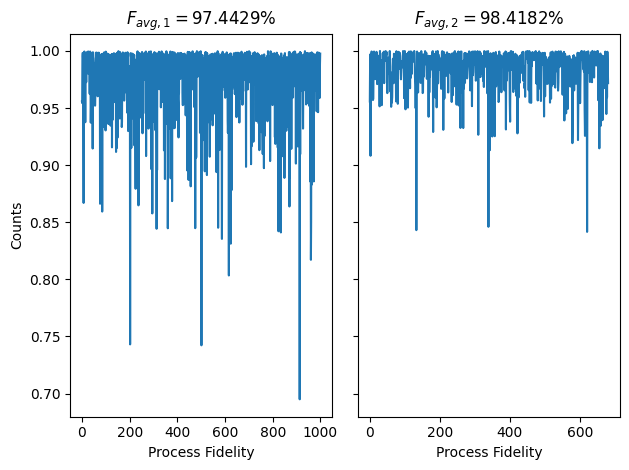

In [214]:
n_bins = 20
fig, axs = plt.subplots(1, 2,sharey=True, tight_layout=True)
# plt.text(0.8,460,s="J_std = 0.5MHz, dBz_std=0.3MHz")
# We can set the number of bins with the *bins* keyword argument.
axs[0].plot(np.abs(Fd_avg))
axs[0].set_title(r'$F_{avg,1} = $' +f'{np.average(np.abs(Fd_avg)):.4%}')
axs[0].set_xlabel("Process Fidelity")
axs[0].set_ylabel("Counts")

axs[1].plot(np.abs(Fd_process))
axs[1].set_title(r'$F_{avg,2} = $' +f'{np.average(np.abs(Fd_process)):.4%}')
axs[1].set_xlabel("Process Fidelity")

Text(0.5, 0, 'Process Fidelity')

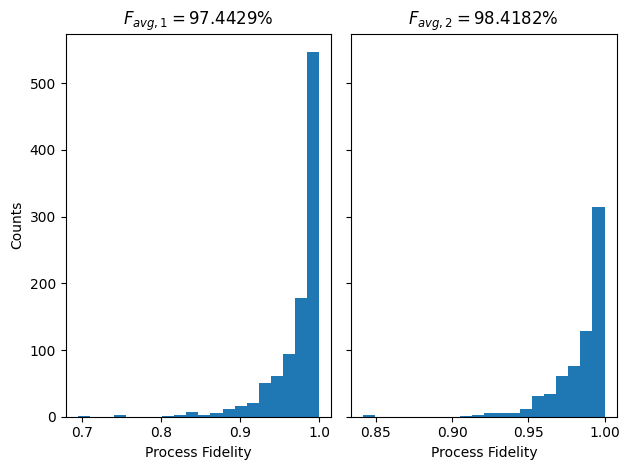

In [204]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
n_bins = 20
fig, axs = plt.subplots(1, 2,sharey=True, tight_layout=True)
# plt.text(0.8,460,s="J_std = 0.5MHz, dBz_std=0.3MHz")
# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(np.abs(Fd_avg), bins=n_bins)
axs[0].set_title(r'$F_{avg,1} = $' +f'{np.average(np.abs(Fd_avg)):.4%}')
axs[0].set_xlabel("Process Fidelity")
axs[0].set_ylabel("Counts")

axs[1].hist(np.abs(Fd_process), bins=n_bins)
axs[1].set_title(r'$F_{avg,2} = $' +f'{np.average(np.abs(Fd_process)):.4%}')
axs[1].set_xlabel("Process Fidelity")

# axs[2].hist(np.abs(Fd_trace), bins=n_bins)
# axs[2].set_title(r'$F_{avg,3} = $' +f'{np.average(np.abs(Fd_process)):.4%}')
# axs[2].set_xlabel("Process Fidelity")
# plt.show()

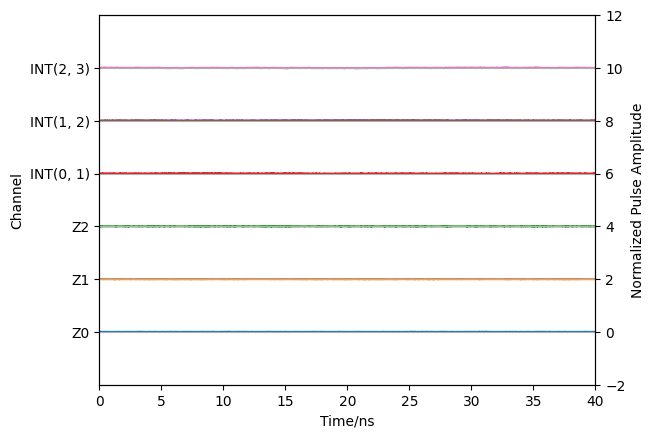

0

In [537]:
%matplotlib inline
## Notice that the all pulses'  amplitude are rescaled by a factor 1/1.2
pl.plot_pulse_sequence(pulse_sequence, simulation_option)

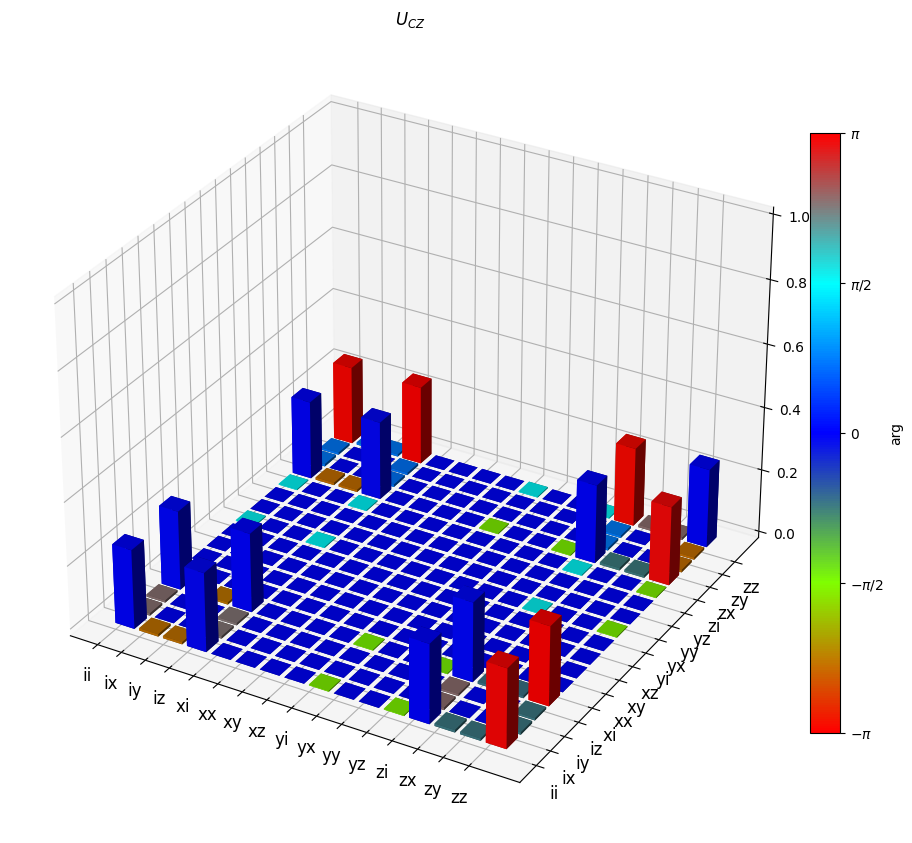

In [223]:
from qutip.tomography import qpt, qpt_plot_combined

U_rho = spre(Uphase) * spost(Uphase.dag())
op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()]] * 2
op_label = [["i", "x", "y", "z"]] * 2
chi = qpt(U_rho, op_basis)
fig = qpt_plot_combined(chi, op_label, r'$U_{CZ}$', figsize=(14,8))
%matplotlib inline
plt.show()

## Q factor measurement

In [298]:
freq_list = [ # GHz
    [0, 10],
    [0, 10]
]

inter_list = [
    [{
        "v01": 0,
        "v00": 1,
        "v11": -1
    },
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    }],
    [{
        "v01": 1,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": 1,
        "v00": 0,
        "v11": 0
    }]
    ,
    [{
        "v01": -1j,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": -1j,
        "v00": 0,
        "v11": 0
    }]
]

r_dic = {
    "r12": 1e-3
}
r = tools.r2matrix(r_dic, freq_list) # Coupling strength

extra_list=None
## with pulse type XY
driving_list = [
    {
        "W01": 1j   # W01 represents \Omega_{01}, for the qubit with index 0
    },
    {
        "W01": 1j
    }
]

## with pulse type Z
bias_list = [ # Default, Z00 = 0
    {
        "Z11": 1
    },
    {
        "Z11": 1
    }
]

gamma_list = [{"z":1/50}, {"z": 1/50}]
# gamma_list = None

_system_arb1 = aqs.arb_qubit_system(freq_list, inter_list, extra_list=extra_list, r =r, driving_list=driving_list, bias_list=bias_list, gamma_list=gamma_list)

# System initial state & eigenstate
state_00, E_00, _= _system_arb1.get_eigenstates_energy((0,0))
state_10, E_10, _= _system_arb1.get_eigenstates_energy((1,0))
state_01, E_01, _= _system_arb1.get_eigenstates_energy((0,1))
state_11, E_11, _= _system_arb1.get_eigenstates_energy((1,1))

# spin basis
state_uu = state_11
state_dd = state_00
state_ud = Qobj(np.array([0,0,1,0]), dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket)
state_du = Qobj(np.array([0,1,0,0]), dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket)

# ST0
state_S = (state_ud-state_du)/np.sqrt(2)
state_T0 = (state_ud+state_du)/np.sqrt(2)

_system_arb1.H

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[6.28318531e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.28255699e+01 1.25663706e-02 0.00000000e+00]
 [0.00000000e+00 1.25663706e-02 6.28255699e+01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.25669989e+02]]

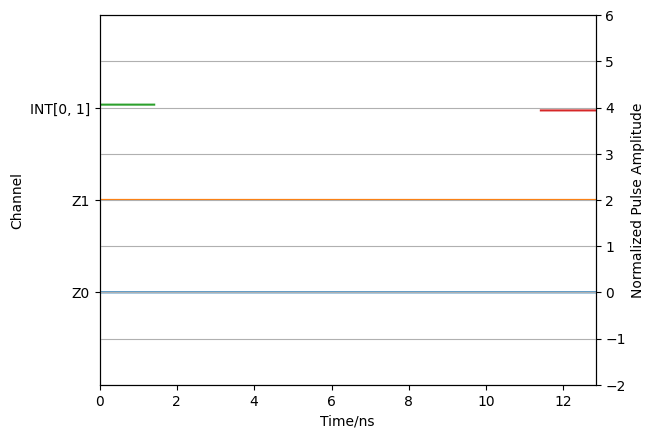

0

In [134]:
half_pi_gt = np.sqrt(2); tau_d=10
bisa_amp = 61.5e-3; t_width = tau_d + half_pi_gt*2

simulation_option = {
    "simulation_time": t_width, # ns
    "simulation_step": 50000,
    "initial_state": [state_ud] # Do multiple simulation
}

pulse_sequence = [
    {
        'pulse_index': 0, # [m,n] represents $\Omega_{mn}$
        'type': "INT",
        'pulse_shape': "square",
        't_delay': 0, # unit in ns
        't_width': half_pi_gt, # unit in ns
        't_plateau':0, # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': bisa_amp+1e-3,#-3.5e-3, # bisa_amp, # XY: Rabi freq; Z: biased frequency
        'q_index': [0,1]
    },
    {
        'pulse_index': 1, # [m,n] represents $\Omega_{mn}$
        'type': "INT",
        'pulse_shape': "square",
        't_delay': tau_d+half_pi_gt, # unit in ns
        't_width': half_pi_gt, # unit in ns
        't_plateau':0, # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': -bisa_amp-1e-3,#-3.5e-3, # bisa_amp, # XY: Rabi freq; Z: biased frequency
        'q_index': [0,1]
    },
    { # Base line J23
        'pulse_index': 4,
        'type': 'Z',
        "pulse_shape": "square",
        't_delay': 0, # unit in ns
        't_width': 0, # unit in ns
        't_plateau':simulation_option['simulation_time'], # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': np.random.normal(0, 0.22e-3),#j23_d*1e-3, # XY: Rabi freq; Z: biased frequency
        'q_index': 0
    },
    { # Base line J23
        'pulse_index': 5,
        'type': 'Z',
        "pulse_shape": "square",
        't_delay': 0, # unit in ns
        't_width': 0, # unit in ns
        't_plateau':simulation_option['simulation_time'], # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': np.random.normal(0, 0.22e-3),#j23_d*1e-3, # XY: Rabi freq; Z: biased frequency
        'q_index': 1
    }
]

%matplotlib inline
## Notice that the all pulses'  amplitude are rescaled by a factor 1/1.2
pl.plot_pulse_sequence(pulse_sequence, simulation_option)

### Energy level

In [573]:
num_level = 4 # Num of level we want to see
j23_scan_space= np.linspace(0.01e-3, 300e-3, 1000)
j_dic =copy.deepcopy(r_dic)

energy_level_list = []
for j23 in j23_scan_space:
    dummy_list = []
    j_dic["r12"] = j23
    j_matrix = tools.r2matrix(j_dic, freq_list)
    _system_arb1 = aqs.arb_qubit_system(freq_list, inter_list, j_matrix, extra_list, gamma_list, driving_list, bias_list)
    for j in range(0,num_level):
        dummy_list.append((_system_arb1.H.eigenenergies()[j] / np.pi/2).real)
    energy_level_list.append(dummy_list)

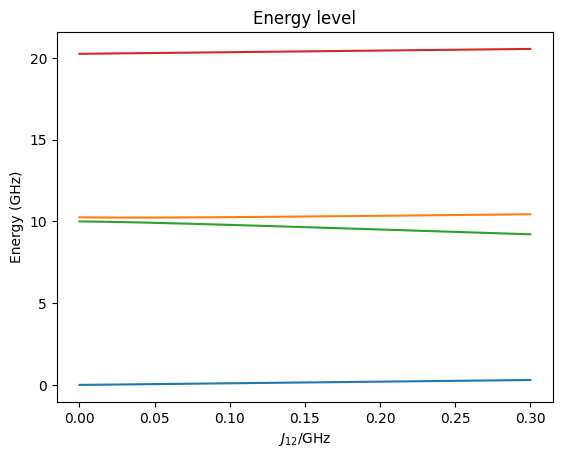

0

In [576]:
%matplotlib inline
pl.plot_Elevel_dynamics(j23_scan_space, energy_level_list, [index_00, index_01, index_10, index_11], "J_{12}")

### Single Mesolve

In [292]:
result_list, _ = _system_arb1.system_dynamics_mesolve(simulation_option, pulse_sequence)

#### Display data dm

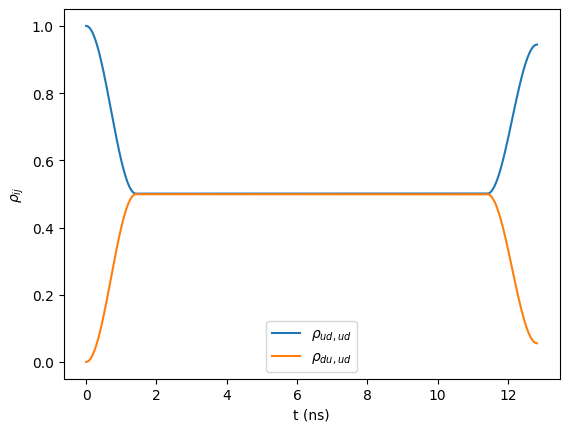

In [293]:
tlist = np.linspace(0, simulation_option['simulation_time'], simulation_option['simulation_step'])

# Select which result you want to see
result = result_list[0]

# Plot
%matplotlib inline
plt.plot(tlist,expect(result.states, ket2dm(state_ud)), label=r'$\rho_{ud,ud}$');
plt.plot(tlist,expect(result.states, ket2dm(state_du)), label=r'$\rho_{du,ud}$');
plt.ylabel(r"$\rho_{ij}$")
plt.xlabel("t (ns)")
plt.legend()
plt.show()

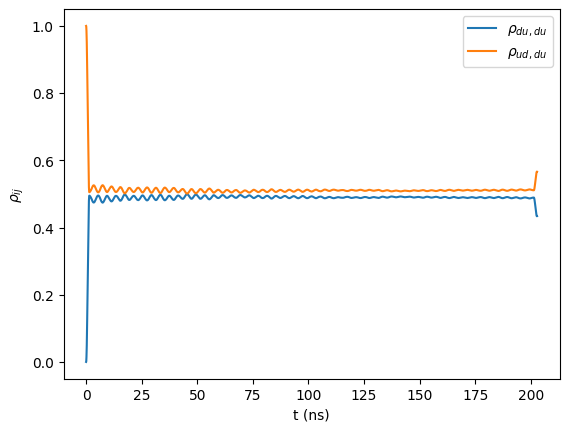

In [73]:
plt.plot(tlist,expect(result.states, ket2dm(state_du)), label=r'$\rho_{du,du}$');
plt.plot(tlist,expect(result.states, ket2dm(state_ud)), label=r'$\rho_{ud,du}$');
plt.ylabel(r"$\rho_{ij}$")
plt.xlabel("t (ns)")
plt.legend()
plt.show()

### Solve ME multiple time

In [85]:
repeat_time = 100
initial01_track10 = []; initial01_track01 = []; initial10_track01 = []; initial10_track10 = []
for trail in tqdm(range(repeat_time)):
    result_list, _ = _system_arb1.system_dynamics_mesolve(simulation_option, pulse_sequence)
    initial01_track10_d = []; initial01_track01_d = []; initial10_track01_d = []; initial10_track10_d = []
    for st in range(len(result_list[0].states)):
        initial01_track10_d.append( np.abs( (state_10.dag() * result_list[0].states[st]).data[0,0] ))
        initial01_track01_d.append( np.abs( (state_01.dag() * result_list[0].states[st]).data[0,0] ))
        initial10_track01_d.append( np.abs( (state_01.dag() * result_list[1].states[st]).data[0,0] ))
        initial10_track10_d.append( np.abs( (state_10.dag() * result_list[1].states[st]).data[0,0] ))
    initial01_track10.append(initial01_track10_d)
    initial01_track01.append(initial01_track01_d)
    initial10_track01.append(initial10_track01_d)
    initial10_track10.append(initial10_track10_d)
initial01_track10 = np.average(initial01_track10, axis=0)
initial01_track01 = np.average(initial01_track01, axis=0)
initial10_track01 = np.average(initial10_track01, axis=0)
initial10_track10 = np.average(initial10_track10, axis=0)
data = [initial01_track10, initial01_track01, initial10_track01, initial10_track10, pulse_sequence]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [43:31<00:00, 26.11s/it]


In [86]:
trail =7
pickle.dump(data, open(f'../../../Data/Qfactor_measure_{trail}.pkl', 'wb'))

In [271]:
trail = 2
data = pickle.load(open(f'../../../Data/Qfactor_measure_{trail}.pkl', 'rb'))
initial01_track10, initial01_track01, initial10_track01, initial10_track10 = data

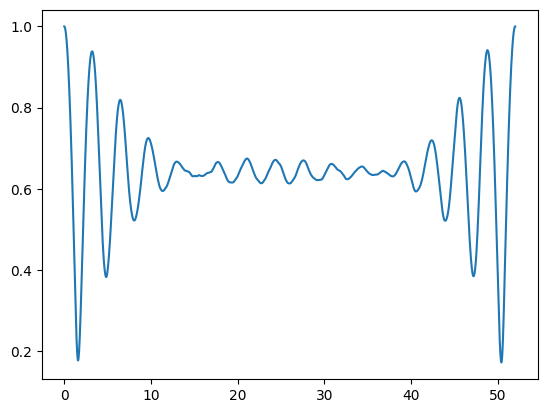

In [272]:
tlist = np.linspace(0, simulation_option["simulation_time"], simulation_option["simulation_step"])
%matplotlib inline
plt.plot(tlist,initial01_track01)
plt.show()

### Mesolve Ramsy

In [303]:
repeat_time = 200
tau_list = np.linspace(0, 200, 50)
ramsy_pop = []
half_pi_gt = np.sqrt(2)
bisa_amp = 61.5e-3

for tau_d in tqdm(tau_list):
    total_t = tau_d + 2*half_pi_gt
    simulation_option = {
        "simulation_time": total_t, # ns
        "simulation_step": 10000,
        "initial_state": [state_S] # Do multiple simulation
    }
    
    initial01_track01 = []
    for trial in tqdm(range(repeat_time),leave=None):

        pulse_sequence = [
            {
                'pulse_index': 0, # [m,n] represents $\Omega_{mn}$
                'type': "INT",
                'pulse_shape': "square",
                't_delay': 0, # unit in ns
                't_width': half_pi_gt, # unit in ns
                't_plateau':0, # unit in ns
                'freq': 0, # unit in GHz; Z pulse does not use it
                'phase': 0, # unit in rad; Z pulse does not use it
                'amplitude': bisa_amp,#-3.5e-3, # bisa_amp, # XY: Rabi freq; Z: biased frequency
                'q_index': [0,1]
            },
            {
                'pulse_index': 1, # [m,n] represents $\Omega_{mn}$
                'type': "INT",
                'pulse_shape': "square",
                't_delay': tau_d+half_pi_gt, # unit in ns
                't_width': half_pi_gt, # unit in ns
                't_plateau':0, # unit in ns
                'freq': 0, # unit in GHz; Z pulse does not use it
                'phase': 0, # unit in rad; Z pulse does not use it
                'amplitude': -bisa_amp-2e-3,#-3.5e-3, # bisa_amp, # XY: Rabi freq; Z: biased frequency
                'q_index': [0,1]
            },
            {
                'pulse_index': 2, # [m,n] represents $\Omega_{mn}$
                'type': "INT",
                'pulse_shape': "square",
                't_delay': half_pi_gt, # unit in ns
                't_width': tau_d, # unit in ns
                't_plateau':0, # unit in ns
                'freq': 0, # unit in GHz; Z pulse does not use it
                'phase': 0, # unit in rad; Z pulse does not use it
                'amplitude': 5.152e-3+ np.random.normal(0, 0.069e-3),#-3.5e-3, # bisa_amp, # XY: Rabi freq; Z: biased frequency
                'q_index': [0,1]
            },
            {
                'pulse_index': 3, # [m,n] represents $\Omega_{mn}$
                'type': "Z",
                'pulse_shape': "square",
                't_delay': 0, # unit in ns
                't_width': half_pi_gt, # unit in ns
                't_plateau':0, # unit in ns
                'freq': 0, # unit in GHz; Z pulse does not use it
                'phase': 0, # unit in rad; Z pulse does not use it
                'amplitude': 250e-3,#-3.5e-3, # bisa_amp, # XY: Rabi freq; Z: biased frequency
                'q_index': 1
            },
            {
                'pulse_index': 3, # [m,n] represents $\Omega_{mn}$
                'type': "Z",
                'pulse_shape': "square",
                't_delay': tau_d+half_pi_gt, # unit in ns
                't_width': half_pi_gt, # unit in ns
                't_plateau':0, # unit in ns
                'freq': 0, # unit in GHz; Z pulse does not use it
                'phase': 0, # unit in rad; Z pulse does not use it
                'amplitude': 250e-3,#-3.5e-3, # bisa_amp, # XY: Rabi freq; Z: biased frequency
                'q_index': 1
            }
        ]

        result_list, _ = _system_arb1.system_dynamics_mesolve(simulation_option, pulse_sequence)
        initial01_track01.append( np.abs( (state_S.dag() * result_list[0].states[-1]).data[0,0] ))
        # initial01_track01.append(expect(result_list[0].states[-1], ket2dm(state_ud)))
    avg_pop = np.average(initial01_track01)
    ramsy_pop.append(avg_pop)
data = [ramsy_pop, tau_list, [half_pi_gt, repeat_time]]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [45:36<00:00, 54.73s/it]


In [234]:
trail =4
pickle.dump(data, open(f'../../../Data/Qfactor_ramsy_StateS_{trail}.pkl', 'wb'))

In [11]:
trail = 10
data = pickle.load(open(f'../../../Data/Qfactor_ramsy_{trail}.pkl', 'rb'))
# ramsy_pop, tau_list, j23_list, ep_list = data
ramsy_pop, tau_list, j23_list, ep_list, aa = data

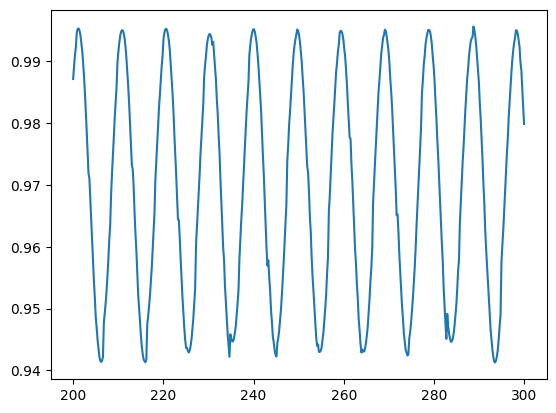

In [235]:
# tlist = np.linspace(0, simulation_option["simulation_time"], simulation_option["simulation_step"])
plt.plot(tau_list,ramsy_pop)
plt.show()

In [339]:
load_list = [9,10,11,12,13,14,15]
pop_list = []; taulst = []
for trail in load_list:
    data = pickle.load(open(f'../../../Data/Qfactor_ramsy_INTnoise_{trail}.pkl', 'rb'))
    # ramsy_pop, tau_list, j23_list, ep_list = data
    ramsy_pop, tau_list, j23_list, ep_list, aa = data
    for kk in range(len(ramsy_pop)):
        pop_list.append(ramsy_pop[kk])
        taulst.append(tau_list[kk])


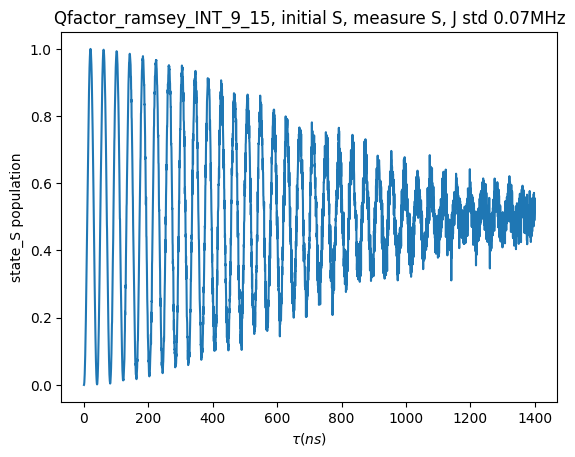

In [342]:
# tlist = np.linspace(0, simulation_option["simulation_time"], simulation_option["simulation_step"])
%matplotlib inline
plt.plot(taulst,pop_list)
plt.title("Qfactor_ramsey_INT_9_15, initial S, measure S, J std 0.07MHz")
plt.xlabel(r'$\tau (ns)$')
plt.ylabel("state_S population")
plt.show()

In [356]:
load_list = [ii for ii in range(6)]
Fd_process_lst = [[],[]]
Fd_avg_lst = [[],[]]
Fd_trace_lst = [[],[]]
J_noise_std_lst = []
J23_noise_std_lst = []
B_noise_std_lst = []
for trail in load_list:
    data = pickle.load(open(f'../../../Data/CZ_1000trail_35ns_{trail}.pkl', 'rb'))
    [Fd_process, Fd_avg, Fd_trace, pulse_sequence, [J_noise_std, J23_noise_std], B_noise_std] = data
    Fd_process_lst[0].append(np.average(Fd_process))
    Fd_process_lst[1].append(sem(Fd_process))
    Fd_avg_lst[0].append(np.average(Fd_avg))
    Fd_avg_lst[1].append(sem(Fd_avg))
    Fd_trace_lst[0].append(np.average(Fd_trace))
    Fd_trace_lst[1].append(sem(Fd_trace))
    J_noise_std_lst.append(J_noise_std)
    J23_noise_std_lst.append(J23_noise_std)
    B_noise_std_lst.append(B_noise_std)

Text(0.5, 1.0, 'CZ_1000trail_35ns_0_to_6,1000-time average CZ gate fidelity, error bar=SEM')

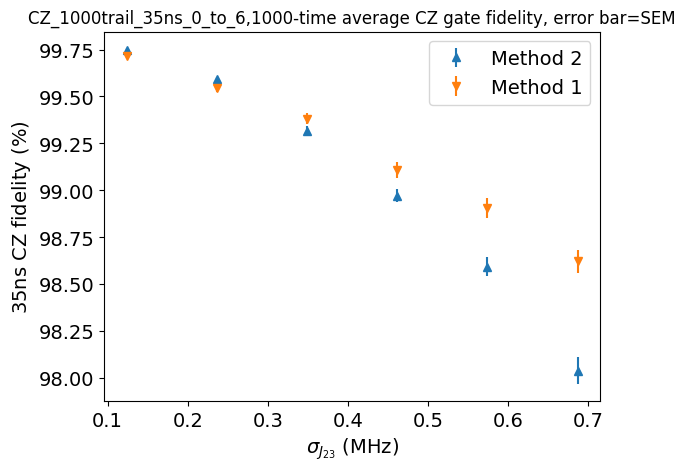

In [388]:
font_size = 14
x_axis =np.array(J23_noise_std_lst)*1e3
plt.errorbar(x_axis,np.array(Fd_avg_lst[0])*100, yerr=np.array(Fd_avg_lst[1])*100, label="Method 2", marker='^', elinewidth=1.5, linewidth=0)
plt.errorbar(x_axis,np.array(Fd_process_lst[0])*100, yerr=np.array(Fd_process_lst[1])*100, label="Method 1", marker='v',elinewidth=1.5,linewidth=0)
# plt.plot(np.array(J23_noise_std_lst)*1e3,Fd_trace_lst, label="trace")
plt.xlabel(r'$\sigma_{J_{23}}$ (MHz)', fontsize=font_size)
plt.ylabel(r"$35$ns CZ fidelity (%)", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.legend(fontsize=font_size)
plt.title("CZ_1000trail_35ns_0_to_6,1000-time average CZ gate fidelity, error bar=SEM")

In [222]:
load_list = [ii for ii in range(5)]
Fd_process_lst = [[],[]]
Fd_avg_lst = [[],[]]
Fd_trace_lst = [[],[]]
J_noise_std_lst = []
J23_noise_std_lst = []
B_noise_std_lst = []
for trail in load_list:
    data = pickle.load(open(f'../../../Data/CZ_1000trail_35ns_B_{trail}.pkl', 'rb'))
    [Fd_process, Fd_avg, Fd_trace, pulse_sequence, [J_noise_std, J23_noise_std], B_noise_std] = data
    Fd_process_lst[0].append(np.average(Fd_process))
    Fd_process_lst[1].append(sem(Fd_process))
    Fd_avg_lst[0].append(np.average(Fd_avg))
    Fd_avg_lst[1].append(sem(Fd_avg))
    Fd_trace_lst[0].append(np.average(Fd_trace))
    Fd_trace_lst[1].append(sem(Fd_trace))
    J_noise_std_lst.append(J_noise_std)
    J23_noise_std_lst.append(J23_noise_std)
    B_noise_std_lst.append(B_noise_std)

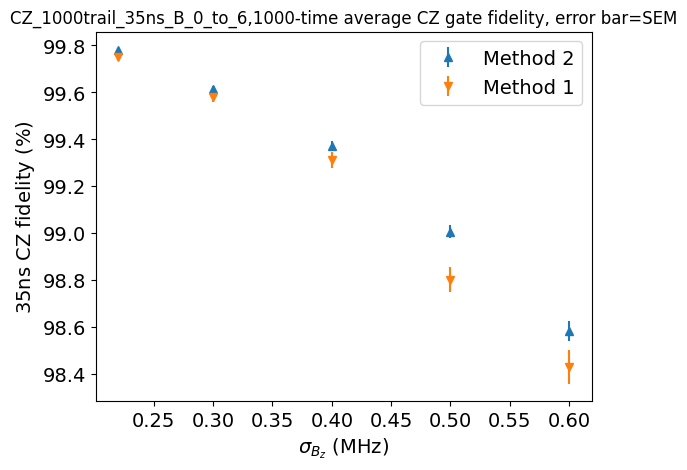

In [226]:
font_size = 14
x_axis =np.array(B_noise_std_lst)*1e3
plt.errorbar(x_axis,np.array(Fd_avg_lst[0])*100, yerr=np.array(Fd_avg_lst[1])*100, label="Method 2", marker='^', elinewidth=1.5, linewidth=0)
plt.errorbar(x_axis,np.array(Fd_process_lst[0])*100, yerr=np.array(Fd_process_lst[1])*100, label="Method 1", marker='v',elinewidth=1.5,linewidth=0)
# plt.plot(np.array(J23_noise_std_lst)*1e3,Fd_trace_lst, label="trace")
plt.xlabel(r'$\sigma_{B_z}$ (MHz)', fontsize=font_size)
plt.ylabel(r"$35$ns CZ fidelity (%)", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.legend(fontsize=font_size)
plt.title("CZ_1000trail_35ns_B_0_to_6,1000-time average CZ gate fidelity, error bar=SEM")
plt.show()

### Mesolve Ramsey DM


In [296]:
repeat_time = 1
tau_list = np.linspace(0, 200, 700)
ramsy_pop = []
half_pi_gt = np.sqrt(2)
bisa_amp = 61.5e-3

for tau_d in tqdm(tau_list):
    total_t = tau_d + 2*half_pi_gt
    simulation_option = {
        "simulation_time": total_t, # ns
        "simulation_step": 10000,
        "initial_state": [state_ud] # Do multiple simulation
    }
    
    initial01_track01 = []
    for trial in range(repeat_time):
        pulse_sequence = [
            {
                'pulse_index': 0, # [m,n] represents $\Omega_{mn}$
                'type': "INT",
                'pulse_shape': "square",
                't_delay': 0, # unit in ns
                't_width': half_pi_gt, # unit in ns
                't_plateau':0, # unit in ns
                'freq': 0, # unit in GHz; Z pulse does not use it
                'phase': 0, # unit in rad; Z pulse does not use it
                'amplitude': bisa_amp+1e-3,#-3.5e-3, # bisa_amp, # XY: Rabi freq; Z: biased frequency
                'q_index': [0,1]
            },
            {
                'pulse_index': 1, # [m,n] represents $\Omega_{mn}$
                'type': "INT",
                'pulse_shape': "square",
                't_delay': tau_d+half_pi_gt, # unit in ns
                't_width': half_pi_gt, # unit in ns
                't_plateau':0, # unit in ns
                'freq': 0, # unit in GHz; Z pulse does not use it
                'phase': 0, # unit in rad; Z pulse does not use it
                'amplitude': -bisa_amp-1e-3,#-3.5e-3, # bisa_amp, # XY: Rabi freq; Z: biased frequency
                'q_index': [0,1]
            },
            # { # Base line J23
            #     'pulse_index': 4,
            #     'type': 'Z',
            #     "pulse_shape": "square",
            #     't_delay': 0, # unit in ns
            #     't_width': 0, # unit in ns
            #     't_plateau':simulation_option['simulation_time'], # unit in ns
            #     'freq': 0, # unit in GHz; Z pulse does not use it
            #     'phase': 0, # unit in rad; Z pulse does not use it
            #     'amplitude': np.random.normal(0, 0.0e-3),#j23_d*1e-3, # XY: Rabi freq; Z: biased frequency
            #     'q_index': 0
            # },
            # { # Base line J23
            #     'pulse_index': 5,
            #     'type': 'Z',
            #     "pulse_shape": "square",
            #     't_delay': 0, # unit in ns
            #     't_width': 0, # unit in ns
            #     't_plateau':simulation_option['simulation_time'], # unit in ns
            #     'freq': 0, # unit in GHz; Z pulse does not use it
            #     'phase': 0, # unit in rad; Z pulse does not use it
            #     'amplitude': np.random.normal(0, 0e-3),#j23_d*1e-3, # XY: Rabi freq; Z: biased frequency
            #     'q_index': 1
            # }
        ]

        result_list, _ = _system_arb1.system_dynamics_mesolve(simulation_option, pulse_sequence)
        initial01_track01.append( np.abs( expect(ket2dm(state_ud), result_list[0].states[-1]) ))
        # initial01_track01.append(expect(result_list[0].states[-1], ket2dm(state_ud)))
    avg_pop = np.average(initial01_track01)
    ramsy_pop.append(avg_pop)
data = [ramsy_pop, tau_list, [half_pi_gt, repeat_time]]

  0%|          | 0/700 [00:00<?, ?it/s]

100%|██████████| 700/700 [02:11<00:00,  5.34it/s]


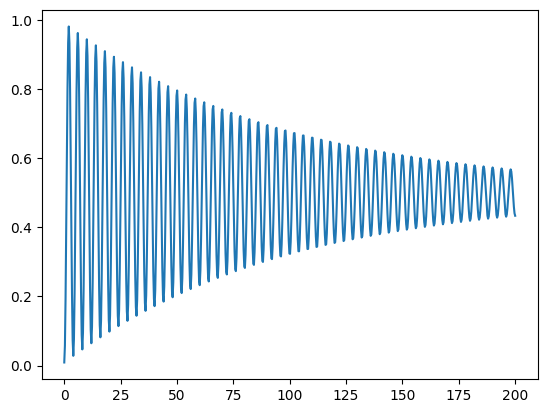

In [297]:
plt.plot(tau_list,ramsy_pop)
plt.show()

### Display data

In [119]:
# state that you want to plot each simulation
interested_state = [
                    [state_ud, state_du]
                    ]
# Convert the variable name to string in order to make legend in the plot
interested_state_label = var_name2str(interested_state)
initial_state_label = var_name2str(simulation_option["initial_state"])

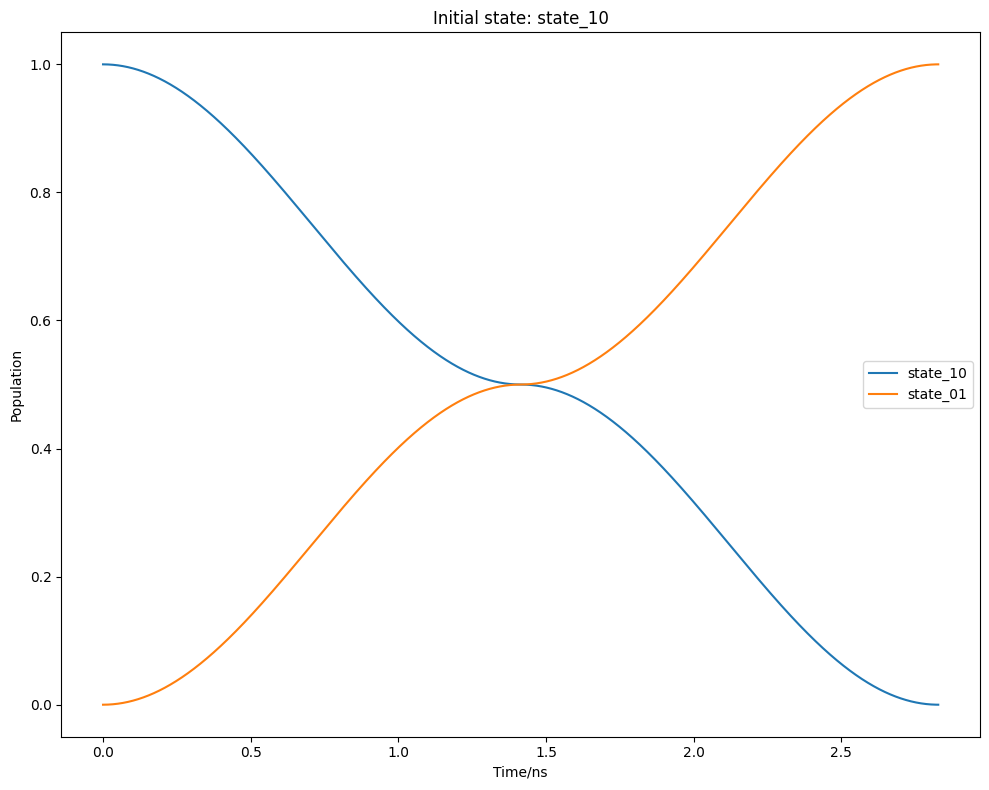

0

In [120]:
%matplotlib inline
# plot state population evolution
pl.plot_population_evolution(_system_arb1, result_list, simulation_option, interested_state, interested_state_label, initial_state_label)

## Single Qubit gate calibration 

In [244]:
freq_list = [ # GHz
    [0, 10.35],
    [0, 10]
]

inter_list = [
    [{
        "v01": 0,
        "v00": 1,
        "v11": -1
    },
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    }],
    [{
        "v01": 1,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": 1,
        "v00": 0,
        "v11": 0
    }]
    ,
    [{
        "v01": -1j,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": -1j,
        "v00": 0,
        "v11": 0
    }]
]

r_dic = {
    "r12": 1e-3
}
r = tools.r2matrix(r_dic, freq_list) # Coupling strength

extra_list=None
## with pulse type XY
driving_list = [
    {
        "W01": 1j   # W01 represents \Omega_{01}, for the qubit with index 0
    },
    {
        "W01": 1j
    }
]

## with pulse type Z
bias_list = [ # Default, Z00 = 0
    {
        "Z11": 1
    },
    {
        "Z11": 1
    }
]

gamma_list = [{"z":1/200}, {"z": 1/200}]

_system_arb1 = aqs.arb_qubit_system(freq_list, inter_list, extra_list=extra_list, r =r, driving_list=driving_list, bias_list=bias_list)

# System initial state & eigenstate
state_00, E_00, _= _system_arb1.get_eigenstates_energy((0,0))
state_10, E_10, _= _system_arb1.get_eigenstates_energy((1,0))
state_01, E_01, _= _system_arb1.get_eigenstates_energy((0,1))
state_11, E_11, _= _system_arb1.get_eigenstates_energy((1,1))

# spin basis
state_uu = state_11
state_dd = state_00
state_ud = Qobj(np.array([0,0,1,0]), dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket)
state_du = Qobj(np.array([0,1,0,0]), dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket)

# ST0
state_S = (state_ud-state_du)/np.sqrt(2)
state_T0 = (state_ud+state_du)/np.sqrt(2)

_system_arb1.H

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[6.28318531e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.28255699e+01 1.25663706e-02 0.00000000e+00]
 [0.00000000e+00 1.25663706e-02 6.50246847e+01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.27869104e+02]]

dBz = 2.4MHz, residual =  1.xx MHz H gate

dBz = 2.9 MHz, residual = 1.xx MHz I gate

dBz = 250 MHz, residual = 0, H: `half_pi_gt = 1.31094
bias_amp = 61.5e-3`

dBz = 250 MHz, residual = 1, H: `half_pi_gt = np.sqrt(2)
bias_amp = 61.5e-3`

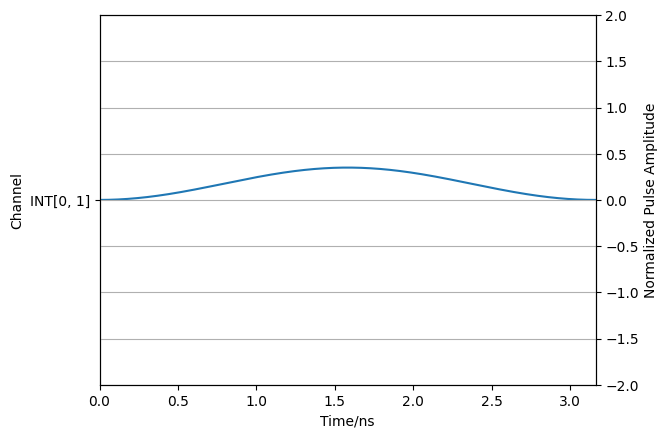

0

In [313]:
half_pi_gt = np.sqrt(10)
bias_amp = 350e-3


simulation_option = {
    "simulation_time": half_pi_gt, # ns
    "simulation_step": 100000,
    "initial_state": [state_ud, state_du] # Do multiple simulation
}

pulse_sequence = [
    { # resitual coupling
        'pulse_index': 0,
        'type': "INT",
        "pulse_shape": "cosine",
        't_delay': 0, # unit in ns
        't_width': simulation_option['simulation_time'], # unit in ns
        't_plateau':0, # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': bias_amp, # XY: Rabi freq; Z: biased frequency
        'q_index': [0,1]
    }
]

%matplotlib inline
## Notice that the all pulses'  amplitude are rescaled by a factor 1/1.2
pl.plot_pulse_sequence(pulse_sequence, simulation_option)

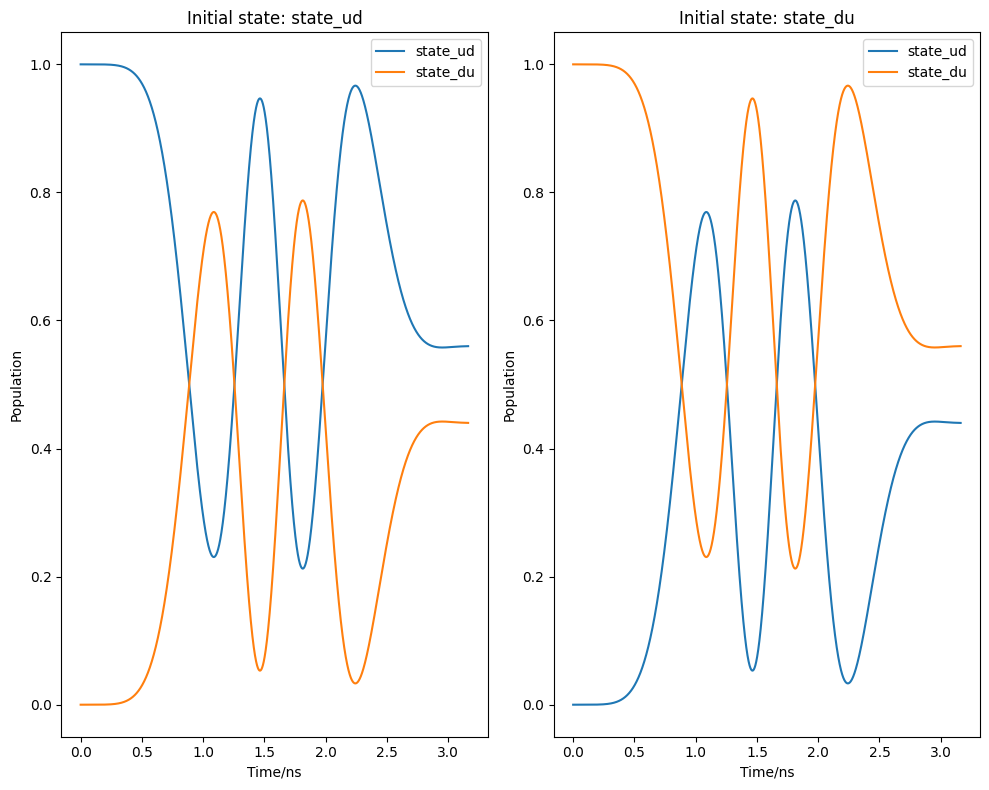

0

In [314]:
result_list, _ = _system_arb1.system_dynamics_mesolve(simulation_option, pulse_sequence)
interested_state = [
                    [state_ud, state_du], [state_ud, state_du]
                    ]
interested_state_label = var_name2str(interested_state)
initial_state_label = var_name2str(simulation_option["initial_state"])

%matplotlib inline
pl.plot_population_evolution(_system_arb1, result_list, simulation_option, interested_state, interested_state_label, initial_state_label)

In [251]:
gt_list = np.linspace(5, 65, 100); dBz = 3.85e-3
pop_list = [[],[]]
for gt in tqdm(gt_list):
    simulation_option = {
        "simulation_time": gt, # ns
        "simulation_step": 10000,
        "initial_state": [state_S] # Do multiple simulation
    }

    pulse_sequence = [
        {
            'pulse_index': 0,
            'type': "INT",
            "pulse_shape": "square",
            't_delay': 0, # unit in ns
            't_width': 0, # unit in ns
            't_plateau':simulation_option['simulation_time'], # unit in ns
            'freq': 0, # unit in GHz; Z pulse does not use it
            'phase': 0, # unit in rad; Z pulse does not use it
            'amplitude': -0.15e-3, # XY: Rabi freq; Z: biased frequency
            'q_index': (0,1)
        },
        {
            'pulse_index': 1,
            'type': "Z",
            "pulse_shape": "square",
            't_delay': 0, # unit in ns
            't_width': 0, # unit in ns
            't_plateau':simulation_option['simulation_time'], # unit in ns
            'freq': 0, # unit in GHz; Z pulse does not use it
            'phase': 0, # unit in rad; Z pulse does not use it
            'amplitude': -0.25 + dBz, # XY: Rabi freq; Z: biased frequency
            'q_index': 1
        }
    ]
    result_list, _ = _system_arb1.system_dynamics_mesolve(simulation_option, pulse_sequence)
    pop_list[0].append(np.abs(( state_T0.dag() * result_list[0].states[-1]).data[0,0]))
    pop_list[1].append(np.abs(( state_S.dag() * result_list[0].states[-1]).data[0,0]))
    

  0%|          | 0/100 [00:00<?, ?it/s]


TypeError: can only concatenate str (not "int") to str

In [ ]:
%matplotlib qt
plt.plot(gt_list, np.abs(pop_list[0]))
plt.plot(gt_list, np.abs(pop_list[1]))